In [4]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from statannotations.Annotator import Annotator
import numpy as np
from scipy.stats import wilcoxon


# Define the directory for the current undersampling rate
pkl_dir = f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files'

# Read and concatenate sr1 data
joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
joined_list = glob.glob(joined_files)
sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

# Read and concatenate sr2 data
joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
joined_list = glob.glob(joined_files)
sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

# Read and concatenate concat data
joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
joined_list = glob.glob(joined_files)
concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

# Read and concatenate add data
joined_files = os.path.join(pkl_dir, 'add_*.pkl')
joined_list = glob.glob(joined_files)
add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)

# Concatenate all dataframes
all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)

# Function to split each row into multiple rows based on cross-validation index
def split_row(row):
    new_rows = []
    for cv_ix, auc in enumerate(row['test_scores']):
        new_row = row.copy()
        new_row['auc'] = auc
        new_row['cv_ix'] = cv_ix
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)

# Apply the split_row function to each row of the dataframe and concatenate the results
result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)


grouped_classifiers = result_df.groupby('classifier')

classifier_dfs = {}
for classifier, group_df in grouped_classifiers:
    classifier_dfs[classifier] = group_df.copy()

mlp_df = classifier_dfs['Multilayer Perceptron']
lr_df = classifier_dfs['Logistic Regression']
svm_df = classifier_dfs['SVM']
nb_df = classifier_dfs['Naive Bayes']

dfs = [mlp_df, lr_df, svm_df, nb_df]
#dfs = [lr_df, svm_df, nb_df]
classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
#classifiers = ['Logistic Regression', 'SVM', 'Naive Bayes']
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
hue_order = sampling_rates
palette = {item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

# Combine all dataframes into one dataframe for plotting
combined_df = pd.concat(dfs)
snr_levels = [2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
#snr_levels = [1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 2.0]

lower_limit = 1.5
combined_df = combined_df[combined_df['snr'] >= lower_limit]

# Define your variables
x = "snr"
y = "auc"
hue = "sampling_rate"
order = snr_levels

# Create the figure and the axes
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 1]})

#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 1]})

for i, classifier in enumerate(classifiers):
    # Filter the data for the current classifier
    data_filtered = combined_df[combined_df['classifier'] == classifier]
    
    # Boxplot
    sns.boxplot(
        x=x, y=y, hue=hue, data=data_filtered, ax=axes[0, i], palette=palette,
        order=order, hue_order=hue_order, showfliers=False
    )

    axes[0, i].set_ylim([0.5, 1.3])

    # Lineplot with error bands
    summary_df = data_filtered.groupby([x, hue]).agg(
        mean_auc=(y, 'mean'),
        std_auc=(y, 'std'),
        count=(y, 'count')
    ).reset_index()
    summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])
    
    sns.lineplot(
        data=summary_df, x=x, y='mean_auc', hue=hue, hue_order=hue_order,
        palette=palette, marker='o', ax=axes[1, i], legend=None
    )
    
    axes[1, i].set_ylim([0.5, 1])

    # Add error bands manually
    for key, grp in summary_df.groupby(hue):
        color = palette[key]
        axes[1, i].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)

    axes[0, i].set_title(f'{classifier}')
    axes[0, i].set_xlabel('')
    if i == 0:
        axes[0, i].set_ylabel('AUC')
        axes[1, i].set_ylabel('AUC')
    else:
        axes[0, i].set_ylabel('')
        axes[1, i].set_ylabel('')
    
    axes[1, i].set_xlabel('SNR')
    
    # Generate pairs for comparisons specific to the filtered data
    pairs = []
    for snr_level in order:
        for pair in combinations(hue_order, 2):
            if pair not in [('sr1', 'sr2'), ('add', 'concat')]:  # Exclude specific pairs
                pairs.append(((snr_level, pair[0]), (snr_level, pair[1])))

    # Function to check if Wilcoxon test can be performed
    def can_perform_wilcoxon(group1, group2):
        try:
            stat, p = wilcoxon(group1, group2)
            return True
        except ValueError:
            return False

    valid_pairs = []
    for pair in pairs:
        snr_level = pair[0][0]
        group1 = data_filtered[(data_filtered[x] == snr_level) & (data_filtered[hue] == pair[0][1])][y]
        group2 = data_filtered[(data_filtered[x] == snr_level) & (data_filtered[hue] == pair[1][1])][y]
        if can_perform_wilcoxon(group1, group2):
            valid_pairs.append(pair)

    # Annotate the plot
    annotator = Annotator(axes[0, i], valid_pairs, data=data_filtered, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
    annotator.configure(test='Mann-Whitney', verbose=2)
    annotator.apply_and_annotate()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Add a super title
fig.suptitle(f"Finnish Dataset AUC vs SNR)", fontsize=16, y=1.02)

# Add grid
for ax_row in axes:
    for ax in ax_row:
        ax.grid(True, which='both', axis='both', linestyle='--')

# Save the combined plot
plt.savefig(f'oulu_hue_layout_combined.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


KeyError: 'test_scores'

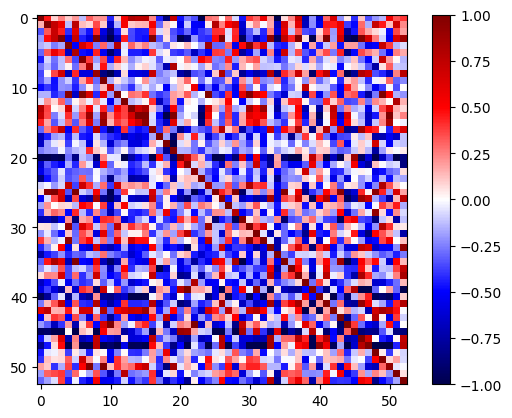

In [72]:
from sklearn import preprocessing
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

tc_data = scipy.io.loadmat('/data/users2/jwardell1/nshor_docker/examples/fbirn-project/FBIRN/000866489781/ses_01/processed/TCOutMax_000866489781.mat')['TCMax'].T
tc_data = scipy.signal.detrend(tc_data, axis=1)
#cov_mat = tc_data[:, np.random.permutation(tc_data.shape[1])] @ tc_data[:, np.random.permutation(tc_data.shape[1])].T
cov_mat = tc_data @ tc_data.T

NETWORK_NAMES = ['SC', 'AUD', 'SM', 'VIS', 'CC', 'DM', 'CB']
SC_IX = np.arange(0,5)
AUC_IX = np.arange(5,7)
SM_IX = np.arange(7, 16) 
VIS_IX = np.arange(16, 25) 
CC_IX = np.arange(25, 42) 
DM_IX = np.arange(42, 49) 
CB_IX = np.arange(49, 53) 

IXs = [SC_IX, AUC_IX, SM_IX, VIS_IX, CC_IX, DM_IX, CB_IX]


permuted_cov_mat = tc_data.copy()

# Iterate over each group of indices in IXs
for indices in IXs:
    # Extract rows corresponding to current indices
    rows_to_permute = permuted_cov_mat[indices]

    # Generate a random permutation of indices
    permuted_indices = np.random.permutation(len(indices))

    # Permute the rows
    permuted_rows = rows_to_permute[permuted_indices]

    # Replace rows in permuted_cov_mat with permuted rows
    permuted_cov_mat[indices] = permuted_rows

# At this point, permuted_cov_mat should have rows permuted such that groups of indices in IXs remain intact
permuted_cov_mat = permuted_cov_mat @ permuted_cov_mat.T
permuted_cov_mat = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(permuted_cov_mat)
plt.imshow(permuted_cov_mat, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()

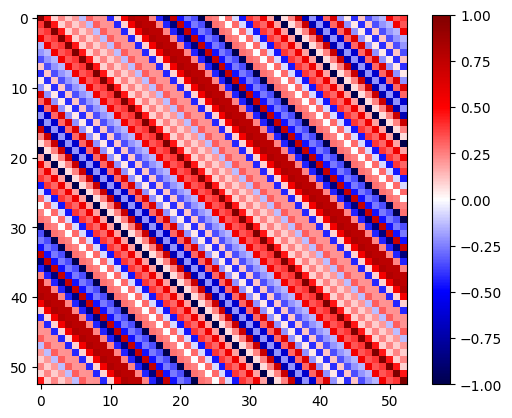

In [78]:
import numpy as np


# Get dimensions of cov_mat
n, _ = permuted_cov_mat.shape

# Extract the first row of cov_mat as the first column of the Toeplitz matrix
first_col = permuted_cov_mat[0]

# Construct the Toeplitz matrix
toeplitz_mat = np.zeros((n, n))
for i in range(n):
    toeplitz_mat[i] = np.roll(first_col, i)  # Shift first_col to create each row of toeplitz_mat

# At this point, toeplitz_mat is the Toeplitz matrix constructed from cov_mat

plt.clf()
plt.imshow(toeplitz_mat, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()

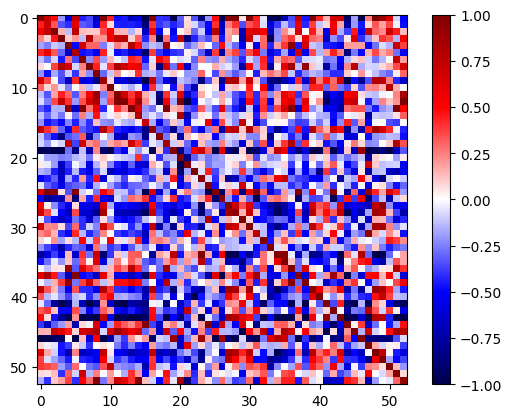

In [88]:
import numpy as np

tc_data = scipy.io.loadmat('/data/users2/jwardell1/nshor_docker/examples/fbirn-project/FBIRN/000866489781/ses_01/processed/TCOutMax_000866489781.mat')['TCMax'].T
tc_data = scipy.signal.detrend(tc_data, axis=1)
#cov_mat = tc_data[:, np.random.permutation(tc_data.shape[1])] @ tc_data[:, np.random.permutation(tc_data.shape[1])].T
cov_mat = tc_data @ tc_data.T


# Get dimensions of cov_mat
n, _ = cov_mat.shape

# Create a copy of cov_mat to modify
flipped_cov_mat = cov_mat.copy()

# Flip the lower triangle
for i in range(n):
    for j in range(i):
        flipped_cov_mat[i, j] = cov_mat[j, i]

# At this point, flipped_cov_mat contains the covariance matrix with the lower triangle flipped
flipped_cov_mat = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(flipped_cov_mat)
plt.clf()
plt.imshow(flipped_cov_mat, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
plt.colorbar()

Processed subject 000300655084
Processed subject 000907477089
Processed subject 001052733667
Processed subject 001374718419


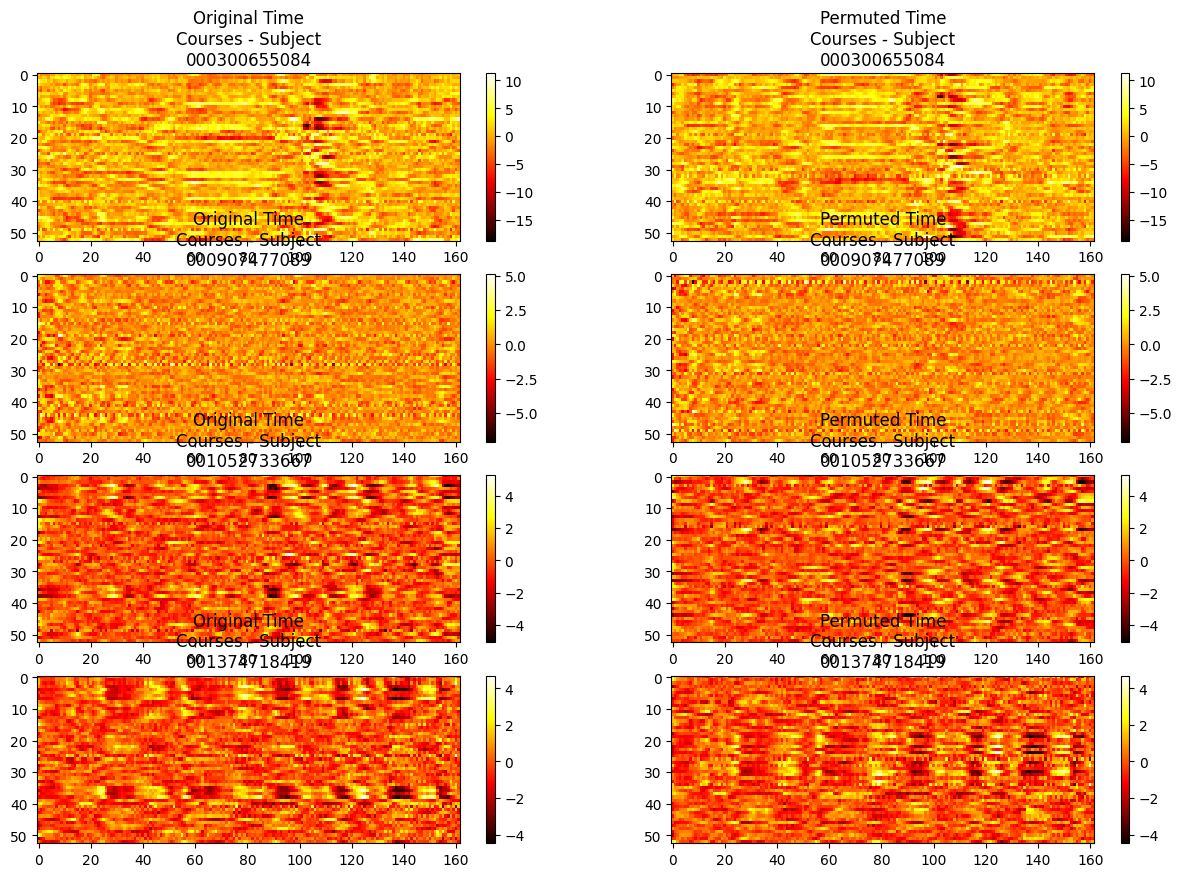

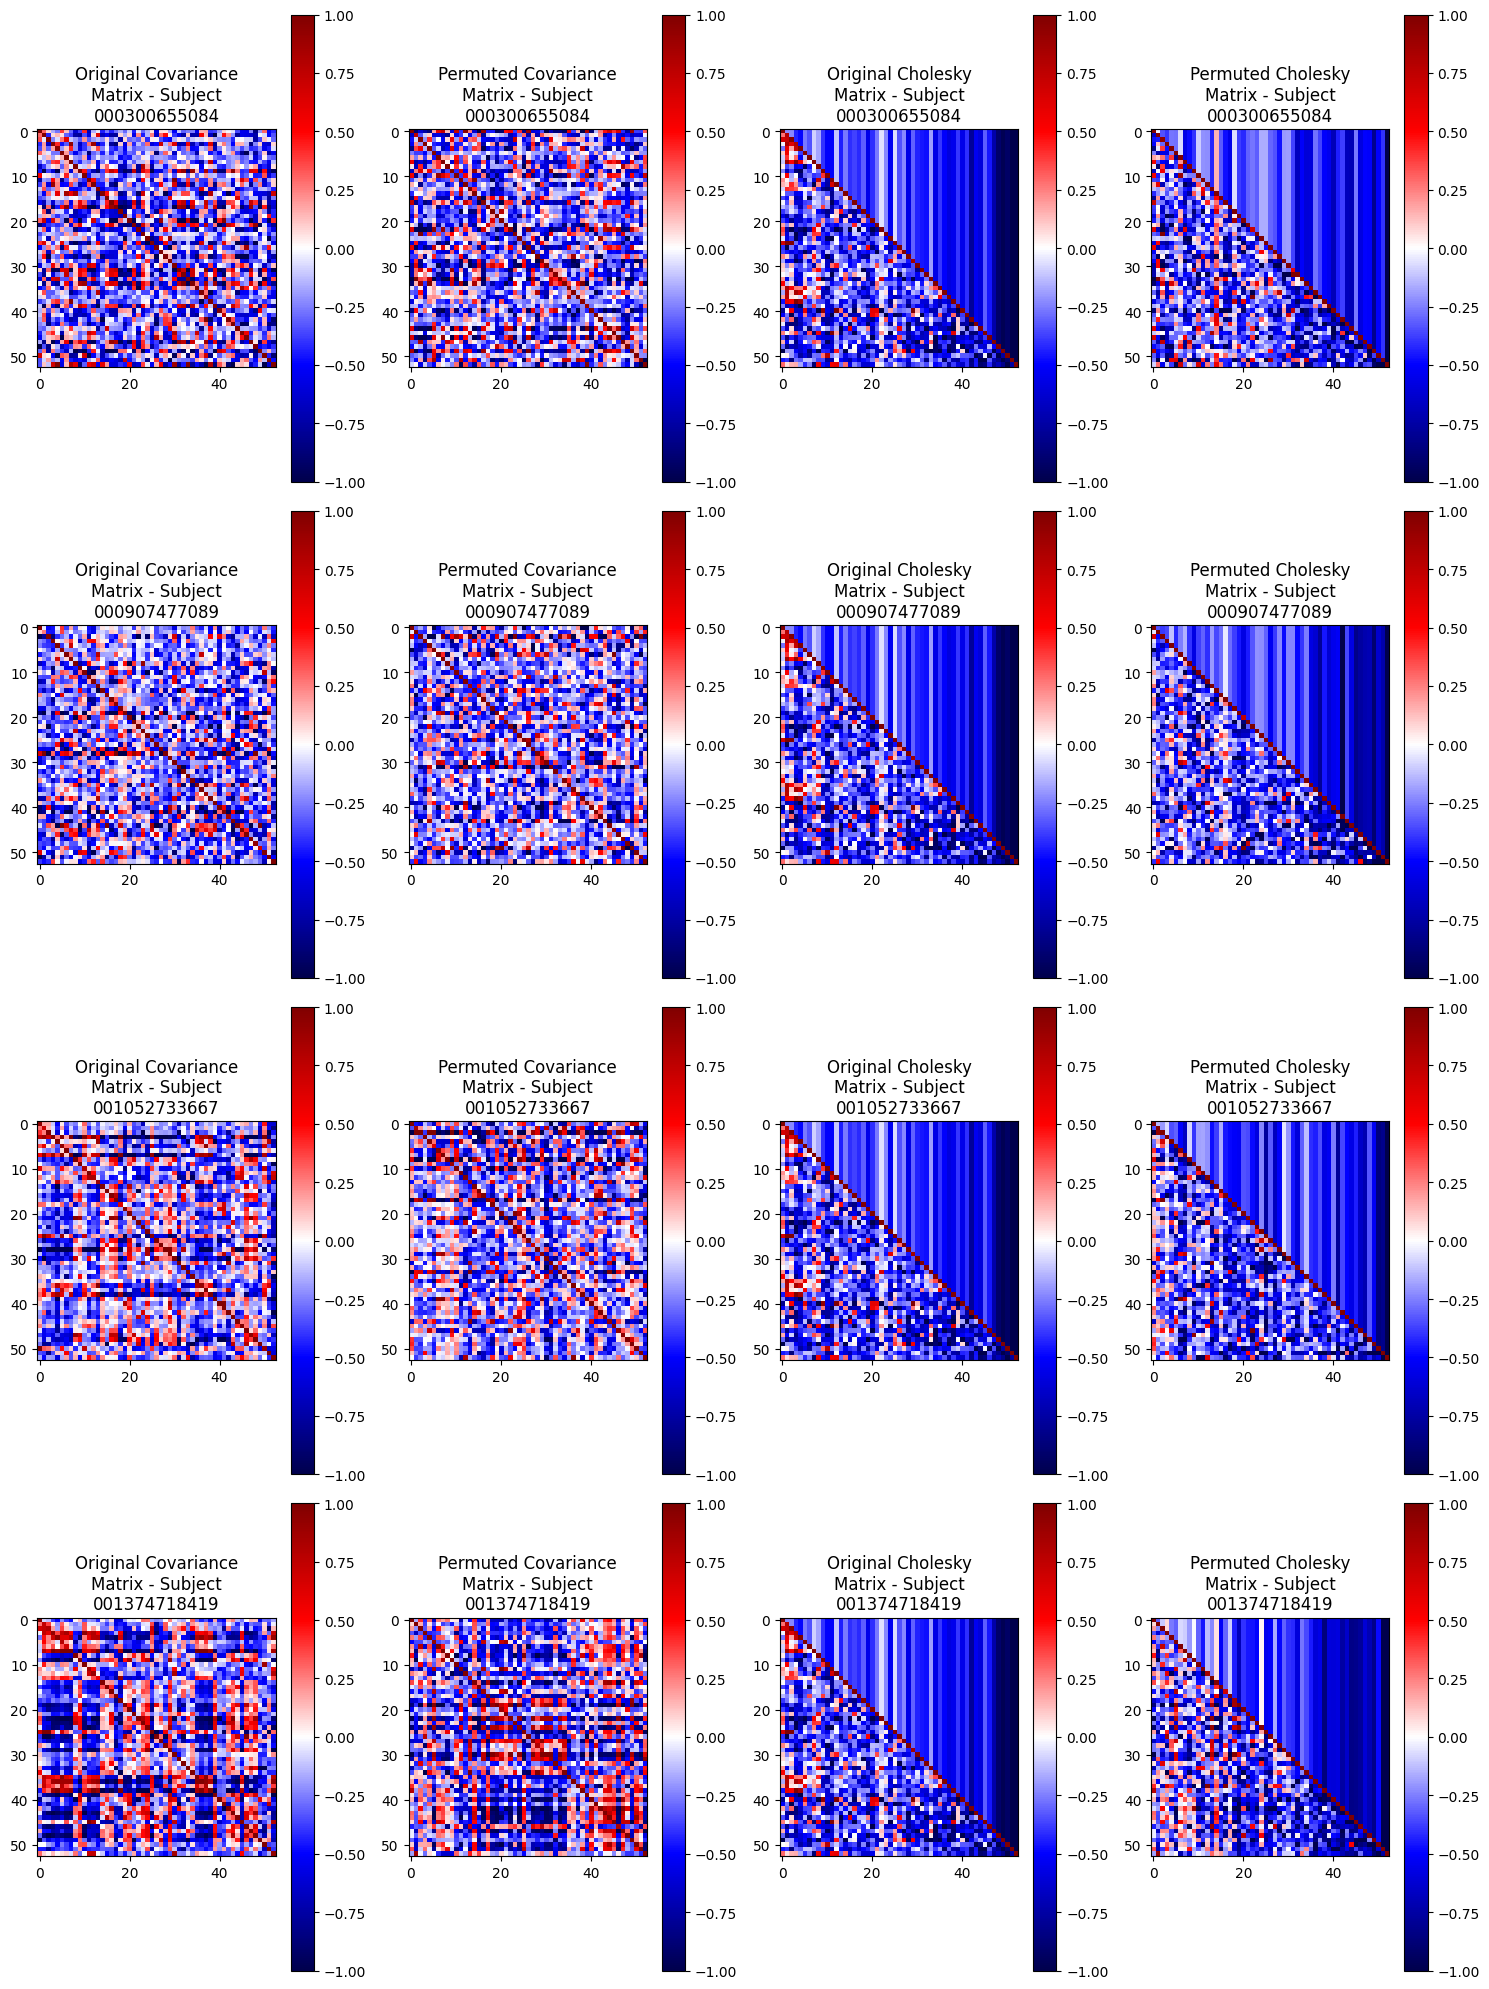

<Figure size 640x480 with 0 Axes>

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [24]:
import numpy as np
import scipy.io
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import signal
from textwrap import wrap

# Define the subject IDs and the base path
subject_ids = ['000300655084', '000907477089', '001052733667', '001374718419']
base_path = '/data/users2/jwardell1/nshor_docker/examples/fbirn-project'
cov_path = os.path.join(base_path, 'COV')

# Create the COV directory if it doesn't exist
if not os.path.exists(cov_path):
    os.makedirs(cov_path)

# Initialize subplot index for covariance and Cholesky matrices
idx = 1

# Create a figure for covariance and Cholesky matrices
plt.figure(1, figsize=(15, 20))

# Initialize subplot index for time courses
tc_idx = 1

# Create a figure for time courses
plt.figure(2, figsize=(15, 10))

# Process each subject
for subID in subject_ids:
    # Load the time course data
    mat_file = f'{base_path}/FBIRN/{subID}/ses_01/processed/TCOutMax_{subID}.mat'
    tc_data = scipy.io.loadmat(mat_file)['TCMax']
    
    # Ensure first dimension is 53
    if tc_data.shape[0] != 53:
        tc_data = tc_data.T  # Transpose if necessary
    
    # Detrend time course data
    tc_data = signal.detrend(tc_data, axis=1)
    
    # Compute original covariance matrix
    cov_mat_original = np.cov(tc_data)

    # Permute columns randomly
    permuted_indices = np.random.permutation(tc_data.shape[0])
    permuted_tc_data = tc_data[permuted_indices, :]

    # Compute permuted covariance matrix
    cov_mat_permuted = np.cov(permuted_tc_data)

    
    # Save permuted covariance matrix as .npy
    perm_cov_file = os.path.join(cov_path, f'{subID}_cov.npy')
    np.save(perm_cov_file, cov_mat_permuted, allow_pickle=True)
    
    
    # Compute Cholesky decomposition for permuted covariance matrix
    chol_matrix_permuted = np.linalg.cholesky(cov_mat_permuted)
    
    # Save Cholesky decomposition as .npy
    perm_chol_file = os.path.join(cov_path, f'{subID}_chol.npy')
    np.save(perm_chol_file, chol_matrix_permuted, allow_pickle=True)

    # Scale original covariance matrix for plotting
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    cov_mat_original_scaled = scaler.fit_transform(cov_mat_original)
    
    # Scale permuted covariance matrix for plotting
    cov_mat_permuted_scaled = scaler.fit_transform(cov_mat_permuted)
    
    # Scale original Cholesky matrix for plotting
    chol_mat_original_scaled = scaler.fit_transform(chol_matrix_original)
    
    # Scale permuted Cholesky matrix for plotting
    chol_mat_permuted_scaled = scaler.fit_transform(chol_matrix_permuted)
    
    # Plot scaled original covariance matrix
    plt.figure(1)
    plt.subplot(4, 4, idx)
    plt.imshow(cov_mat_original_scaled, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
    plt.colorbar()
    title = f'Original Covariance Matrix - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    # Plot scaled permuted covariance matrix
    plt.subplot(4, 4, idx + 1)
    plt.imshow(cov_mat_permuted_scaled, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
    plt.colorbar()
    title = f'Permuted Covariance Matrix - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    # Plot scaled original Cholesky matrix
    plt.subplot(4, 4, idx + 2)
    plt.imshow(chol_mat_original_scaled, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
    plt.colorbar()
    title = f'Original Cholesky Matrix - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    # Plot scaled permuted Cholesky matrix
    plt.subplot(4, 4, idx + 3)
    plt.imshow(chol_mat_permuted_scaled, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
    plt.colorbar()
    title = f'Permuted Cholesky Matrix - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    # Increment subplot index by 4
    idx += 4

    # Plot original time course data as heatmap
    plt.figure(2)
    plt.subplot(4, 2, tc_idx)
    plt.imshow(tc_data, aspect='auto', cmap='hot', interpolation='nearest')
    plt.colorbar()
    title = f'Original Time Courses - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    # Plot permuted time course data as heatmap
    plt.subplot(4, 2, tc_idx + 1)
    plt.imshow(permuted_tc_data, aspect='auto', cmap='hot', interpolation='nearest')
    plt.colorbar()
    title = f'Permuted Time Courses - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    # Increment time course subplot index by 2
    tc_idx += 2

    print(f'Processed subject {subID}')

# Adjust layout and show the covariance and Cholesky matrices plots
plt.figure(1)
plt.tight_layout()
plt.show()

# Adjust layout and show the time course plots
plt.figure(2)
plt.tight_layout()
plt.show()

print


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.0_sr2 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.560e-03 U_stat=1.100e+01
2.1_sr2 vs. 2.1_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.202e-03 U_stat=9.000e+00
2.2_sr2 vs. 2.2_add: Mann-Whitney-Wilcoxon test two-sided, P_val:7.285e-03 U_stat=1.400e+01
2.3_sr2 vs. 2.3_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.402e-02 U_stat=1.700e+01
2.4_sr2 vs. 2.4_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.212e-01 U_stat=2.900e+01
2.5_sr2 vs. 2.5_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.121e-02 U_stat=2.100e+01
2.6_sr2 vs. 2.6_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.405e-01 U_stat=3.000e+01
2.7_sr2 vs. 2.7_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.764e-02 U_stat=2.200e+01
2.8_sr2 vs. 2.8_add: Mann-Whitney-Wilcoxon test two-sided, P_val:4.586e-

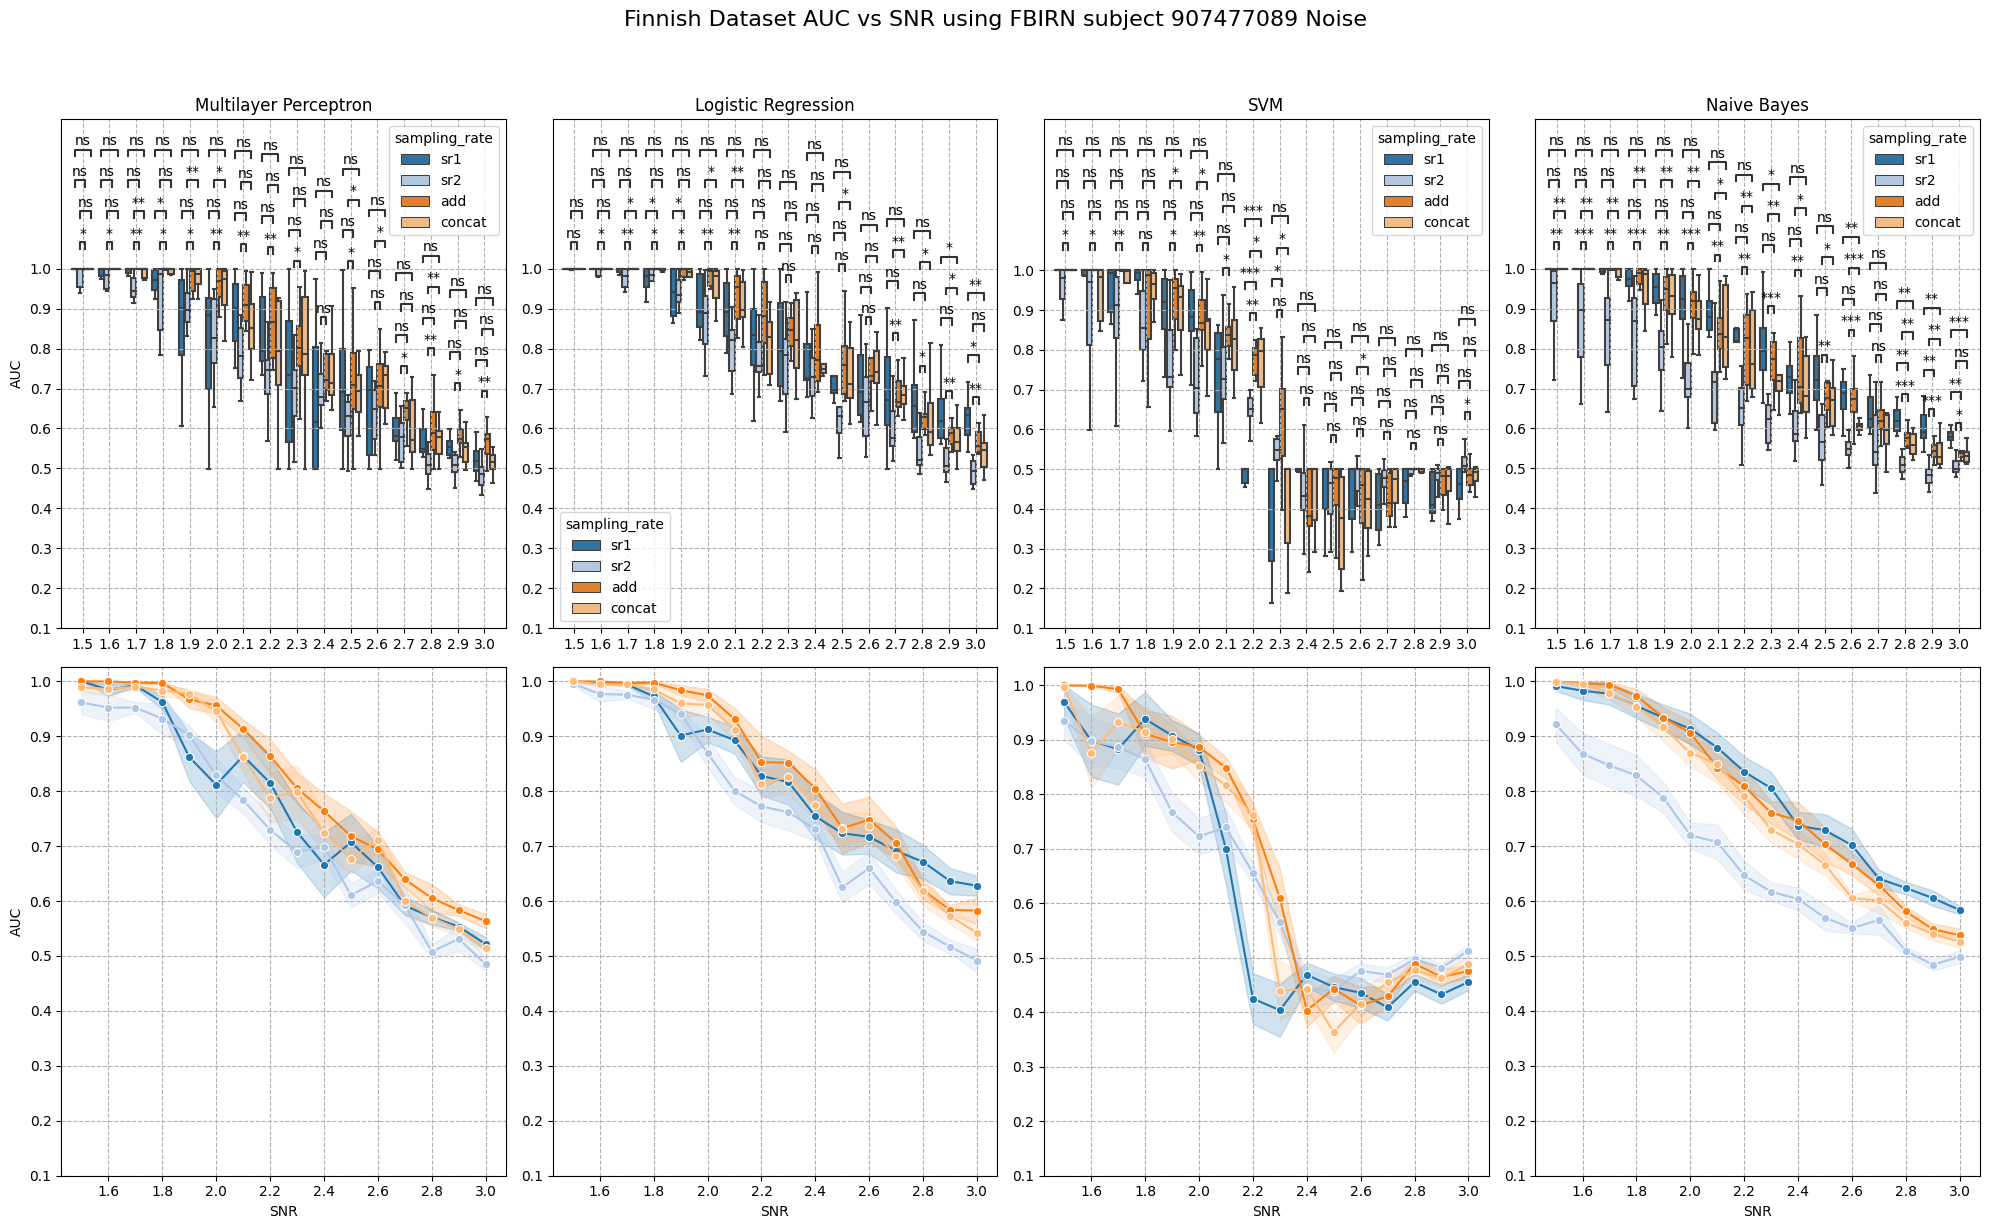

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.0_sr2 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.434e-03 U_stat=1.300e+01
2.1_sr2 vs. 2.1_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.795e-03 U_stat=1.300e+01
2.2_sr2 vs. 2.2_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.831e-02 U_stat=2.050e+01
2.3_sr2 vs. 2.3_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.575e-02 U_stat=2.000e+01
2.4_sr2 vs. 2.4_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.827e-03 U_stat=1.000e+01
2.5_sr2 vs. 2.5_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.108e-02 U_stat=2.100e+01
2.6_sr2 vs. 2.6_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.618e-01 U_stat=3.100e+01
2.7_sr2 vs. 2.7_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.869e-02 U_stat=2.450e+01
2.8_sr2 vs. 2.8_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.828e-

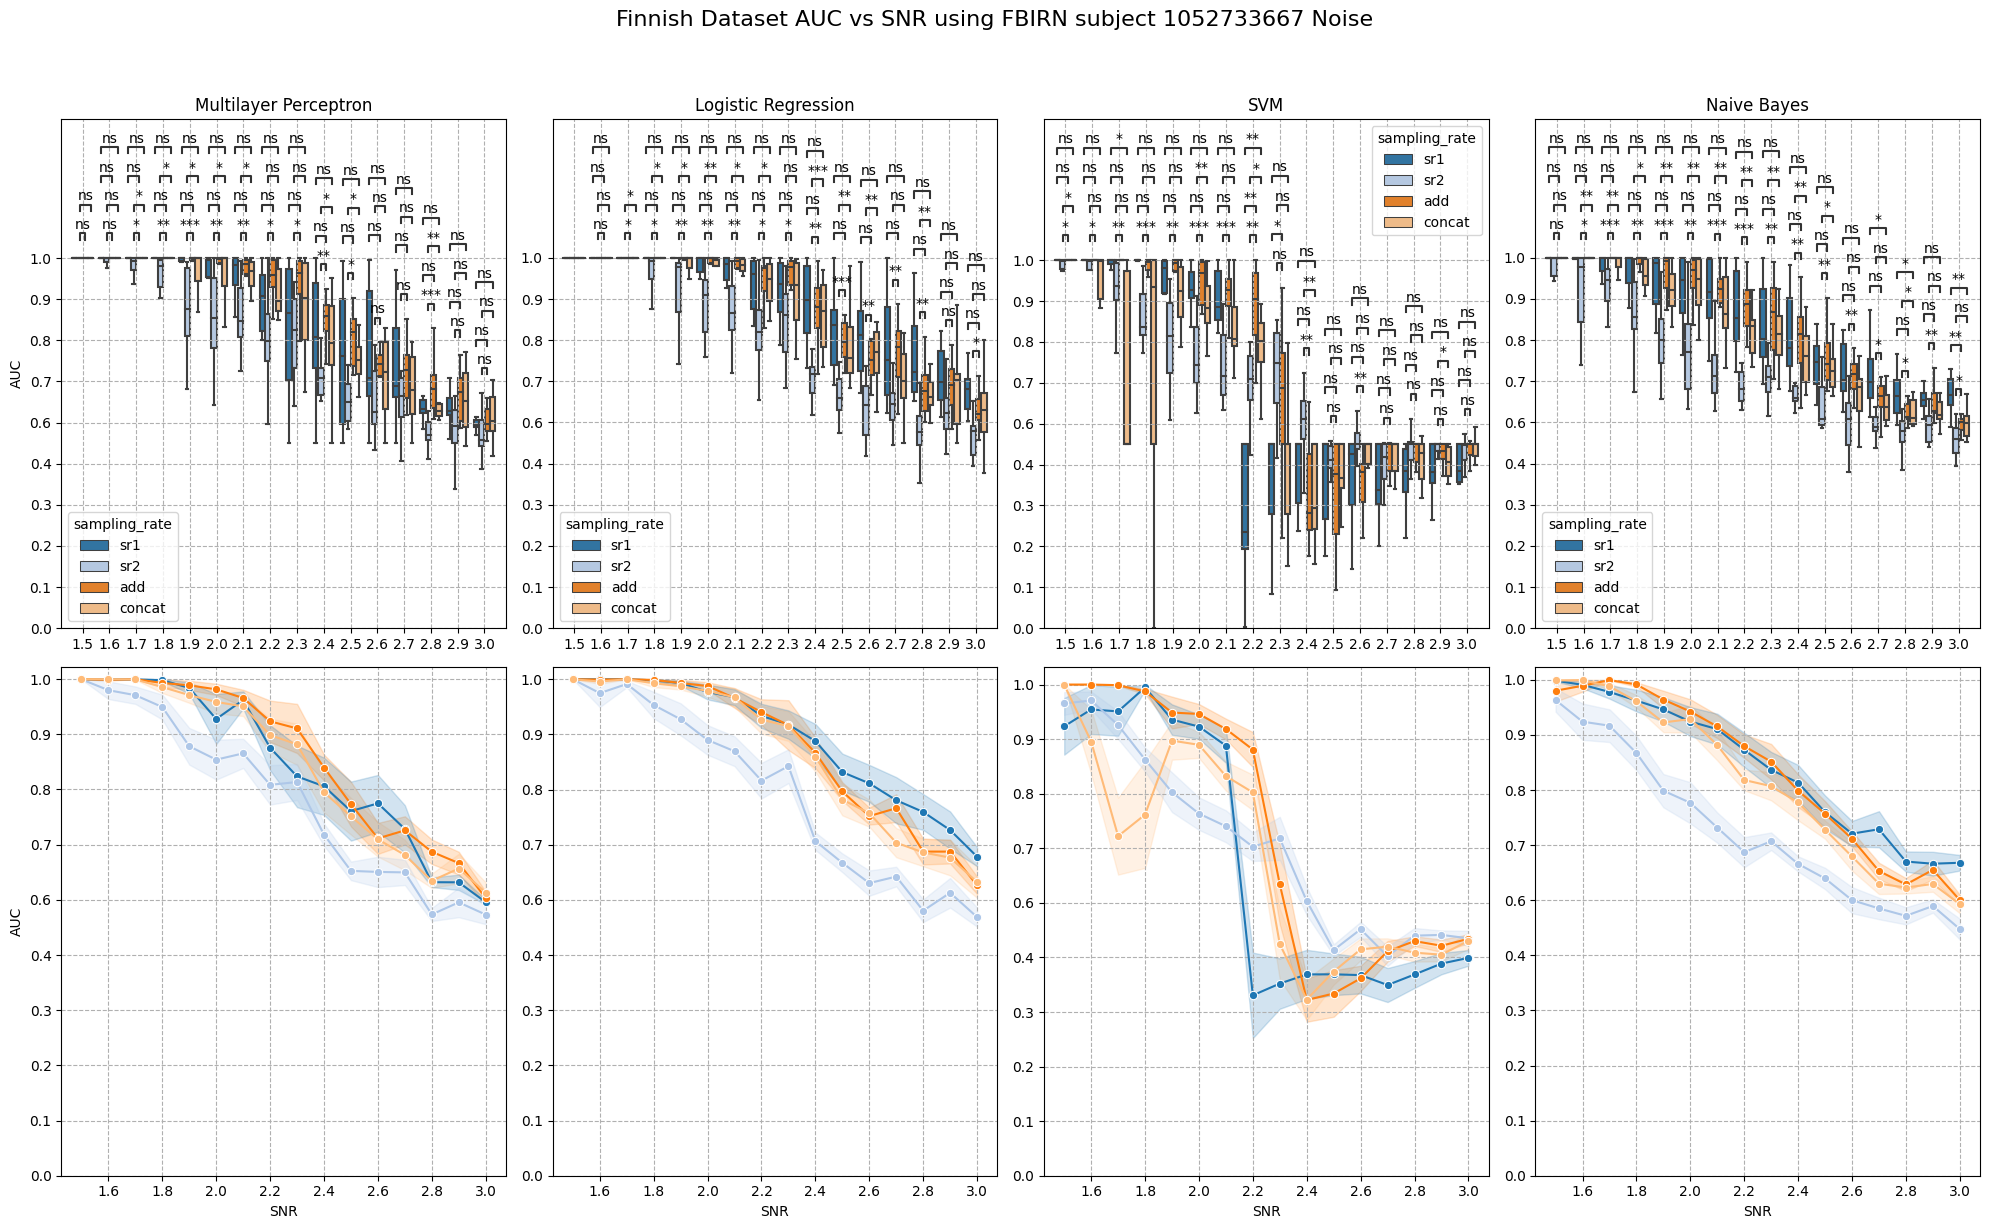

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.0_sr2 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.485e-04 U_stat=0.000e+00
2.1_sr2 vs. 2.1_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.817e-03 U_stat=1.000e+01
2.2_sr2 vs. 2.2_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.817e-04 U_stat=0.000e+00
2.3_sr2 vs. 2.3_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.315e-03 U_stat=7.000e+00
2.4_sr2 vs. 2.4_add: Mann-Whitney-Wilcoxon test two-sided, P_val:4.586e-03 U_stat=1.200e+01
2.5_sr2 vs. 2.5_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.298e-04 U_stat=2.000e+00
2.6_sr2 vs. 2.6_add: Mann-Whitney-Wilcoxon test two-sided, P_val:4.586e-03 U_stat=1.200e+01
2.7_sr2 vs. 2.7_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.795e-03 U_stat=1.300e+01
2.8_sr2 vs. 2.8_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.827e-

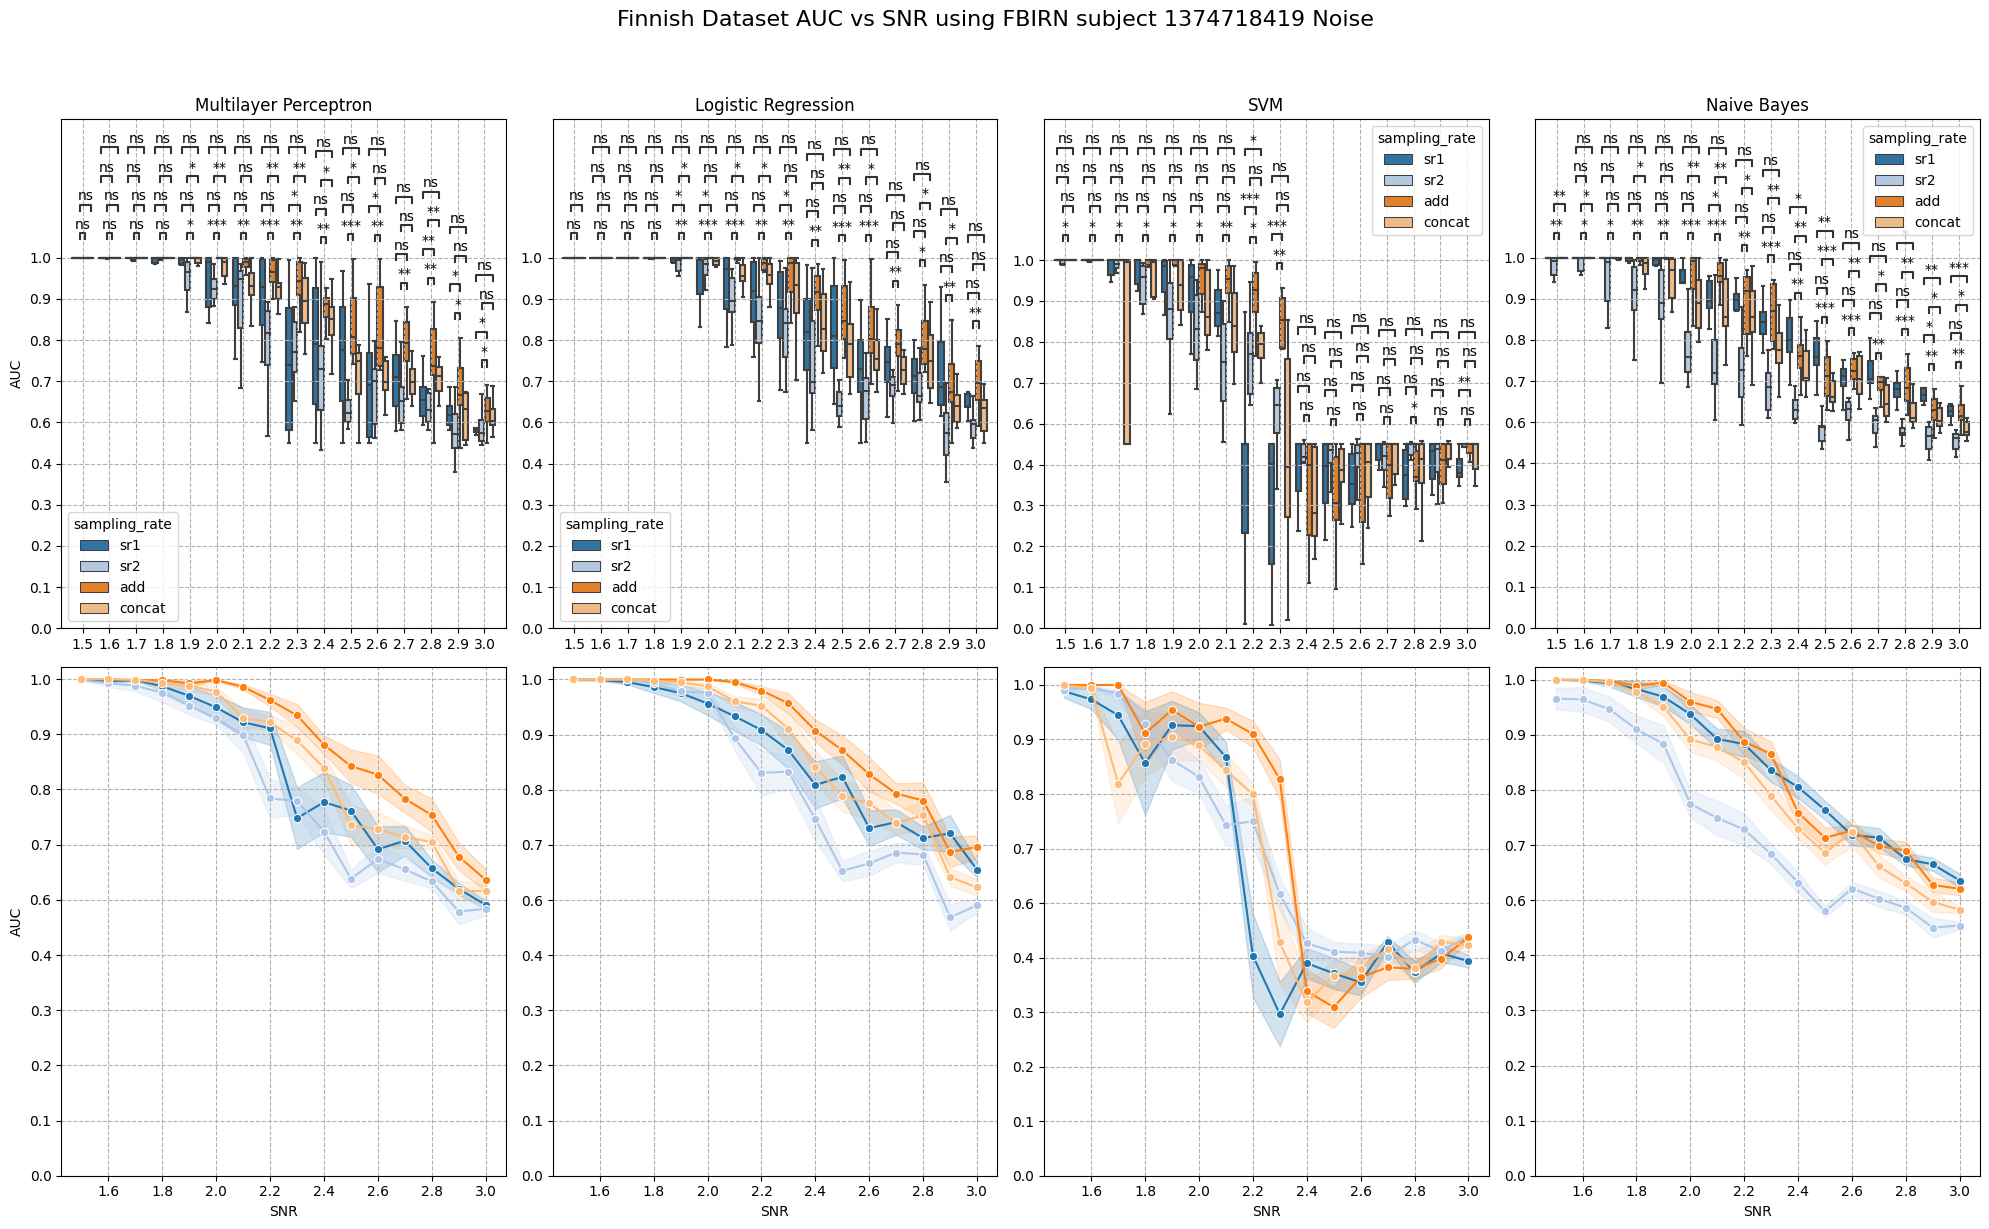

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.0_sr2 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.995e-02 U_stat=2.100e+01
2.1_sr2 vs. 2.1_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.756e-02 U_stat=2.200e+01
2.2_sr2 vs. 2.2_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.764e-02 U_stat=2.200e+01
2.3_sr2 vs. 2.3_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.575e-02 U_stat=2.000e+01
2.4_sr2 vs. 2.4_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.202e-03 U_stat=9.000e+00
2.5_sr2 vs. 2.5_add: Mann-Whitney-Wilcoxon test two-sided, P_val:7.285e-03 U_stat=1.400e+01
2.6_sr2 vs. 2.6_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.795e-03 U_stat=1.300e+01
2.7_sr2 vs. 2.7_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.795e-03 U_stat=1.300e+01
2.8_sr2 vs. 2.8_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.828e-

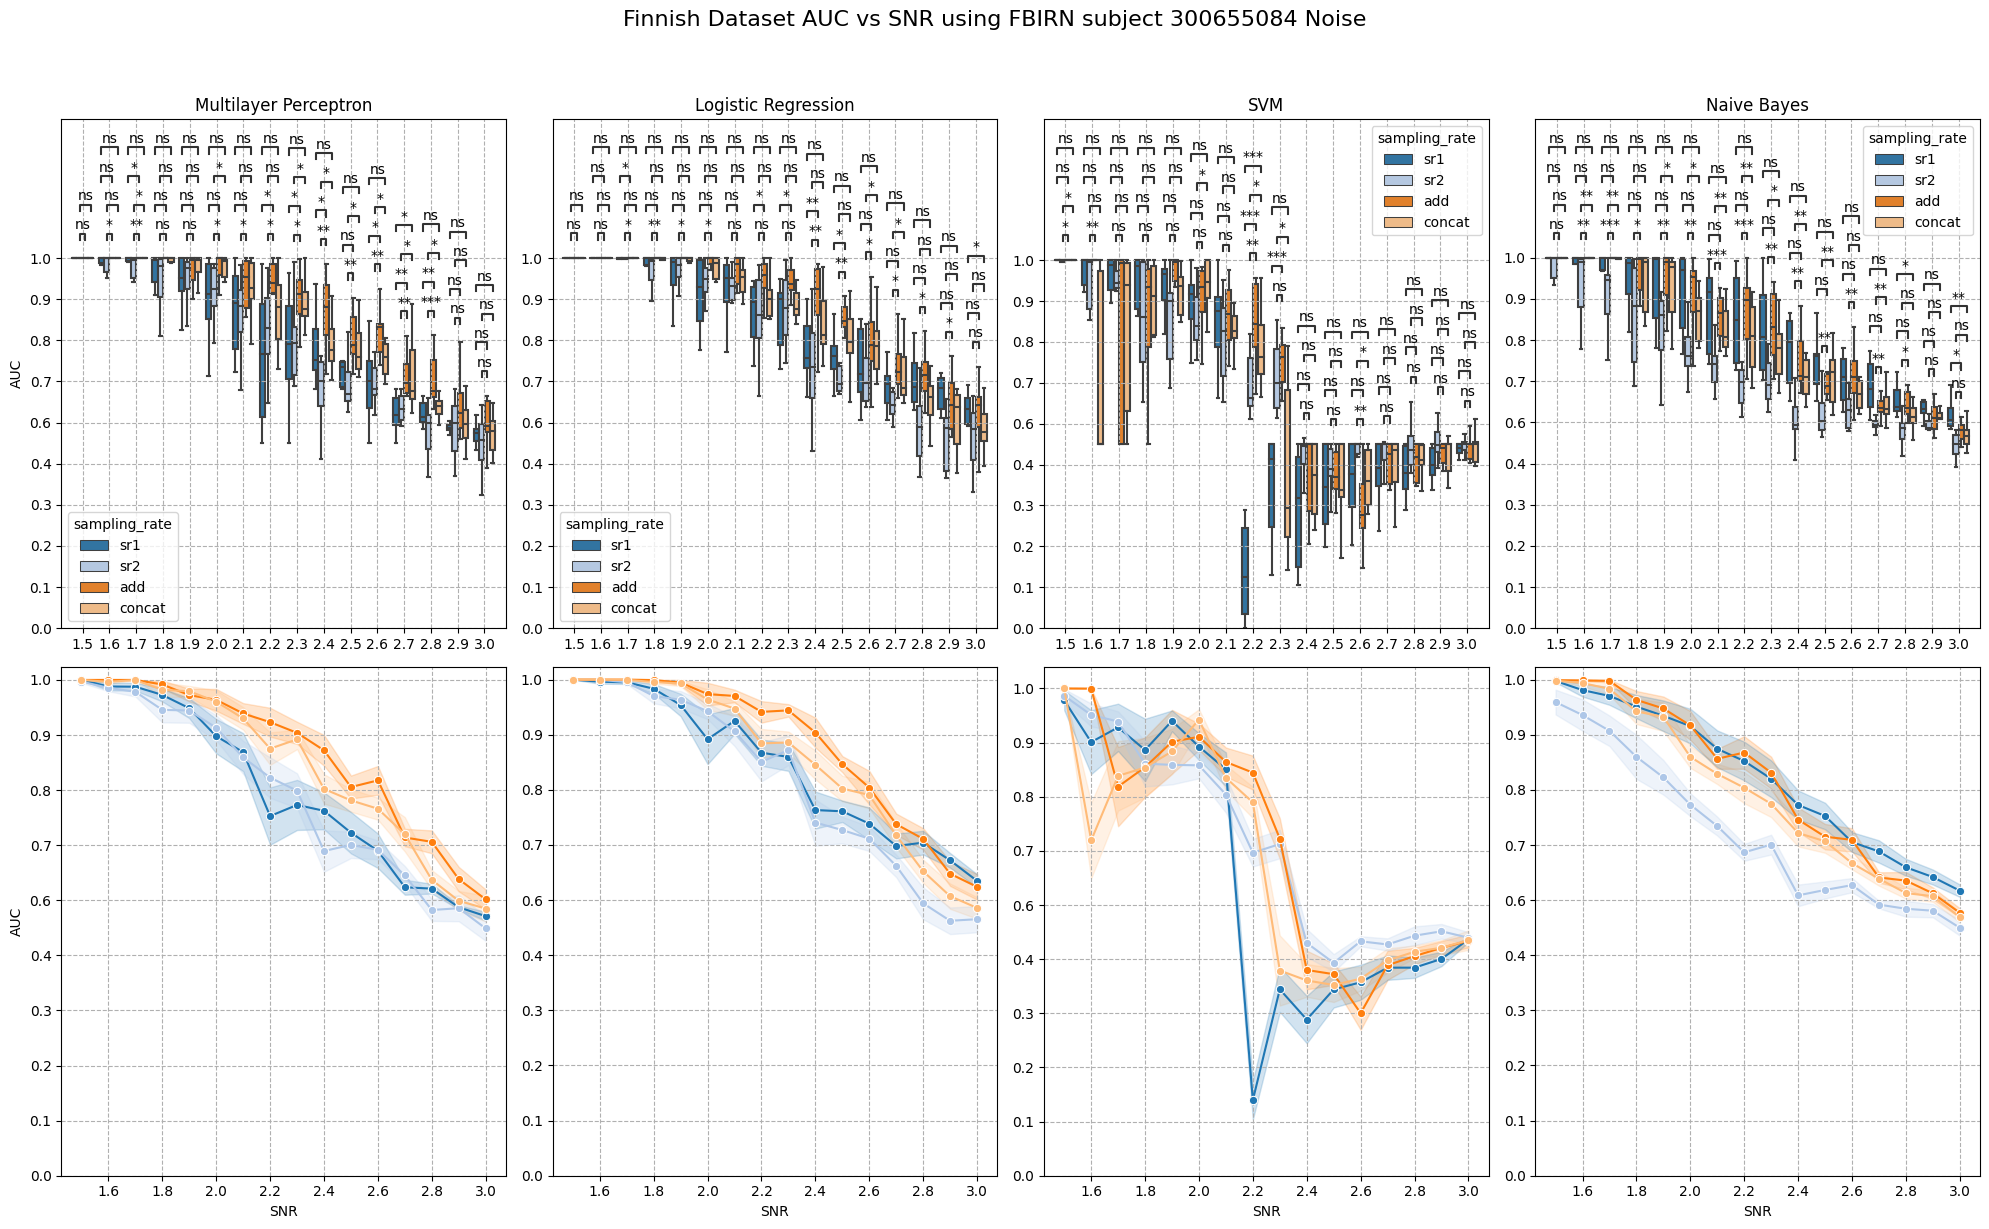

In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from statannotations.Annotator import Annotator
import numpy as np
from scipy.stats import wilcoxon

# List of subject IDs
subject_ids = [
    907477089,
    1052733667,
    1374718419,
    300655084
]

for subID in subject_ids:
    # Define the directory for the current undersampling rate
    pkl_dir = f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/7-17/{subID}'

    # Read and concatenate sr1 data
    joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
    joined_list = glob.glob(joined_files)
    sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

    # Read and concatenate sr2 data
    joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
    joined_list = glob.glob(joined_files)
    sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

    # Read and concatenate concat data
    joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
    joined_list = glob.glob(joined_files)
    concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

    # Read and concatenate add data
    joined_files = os.path.join(pkl_dir, 'add_*.pkl')
    joined_list = glob.glob(joined_files)
    add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)

    # Concatenate all dataframes
    all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)

    # Function to split each row into multiple rows based on cross-validation index
    def split_row(row):
        new_rows = []
        for cv_ix, auc in enumerate(row['test_scores']):
            new_row = row.copy()
            new_row['auc'] = auc
            new_row['cv_ix'] = cv_ix
            new_rows.append(new_row)
        return pd.DataFrame(new_rows)

    # Apply the split_row function to each row of the dataframe and concatenate the results
    result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)

    # Drop the original 'test_scores' column as it's no longer needed
    result_df.drop('test_scores', axis=1, inplace=True)

    grouped_classifiers = result_df.groupby('classifier')

    classifier_dfs = {}
    for classifier, group_df in grouped_classifiers:
        classifier_dfs[classifier] = group_df.copy()

    mlp_df = classifier_dfs['Multilayer Perceptron']
    lr_df = classifier_dfs['Logistic Regression']
    svm_df = classifier_dfs['SVM']
    nb_df = classifier_dfs['Naive Bayes']

    dfs = [mlp_df, lr_df, svm_df, nb_df]
    #dfs = [lr_df, svm_df, nb_df]
    classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
    #classifiers = ['Logistic Regression', 'SVM', 'Naive Bayes']
    sampling_rates = ['sr1', 'sr2', 'add', 'concat']
    hue_order = sampling_rates
    palette = {item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

    # Combine all dataframes into one dataframe for plotting
    combined_df = pd.concat(dfs)
    snr_levels = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0]
    #snr_levels = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

    lower_limit = 1.5
    combined_df = combined_df[combined_df['snr'] >= lower_limit]

    # Define your variables
    x = "snr"
    y = "auc"
    hue = "sampling_rate"
    order = snr_levels

    # Create the figure and the axes
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 1]})

    # Collect y-limits for determining the common range
    all_y_vals = []

    for i, classifier in enumerate(classifiers):
        # Filter the data for the current classifier
        data_filtered = combined_df[combined_df['classifier'] == classifier]
        
        # Boxplot
        sns.boxplot(
            x=x, y=y, hue=hue, data=data_filtered, ax=axes[0, i], palette=palette,
            order=order, hue_order=hue_order, showfliers=False
        )

        # Lineplot with error bands
        summary_df = data_filtered.groupby([x, hue]).agg(
            mean_auc=(y, 'mean'),
            std_auc=(y, 'std'),
            count=(y, 'count')
        ).reset_index()
        summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])
        
        sns.lineplot(
            data=summary_df, x=x, y='mean_auc', hue=hue, hue_order=hue_order,
            palette=palette, marker='o', ax=axes[1, i], legend=None
        )
        
        # Add error bands manually
        for key, grp in summary_df.groupby(hue):
            color = palette[key]
            axes[1, i].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)
        
        # Collect y-values
        all_y_vals.extend(data_filtered[y].values)
        
        axes[0, i].set_title(f'{classifier}')
        axes[0, i].set_ylim(0.2)
        axes[1, i].set_ylim(0.4)
        axes[0, i].set_xlabel('')
        if i == 0:
            axes[0, i].set_ylabel('AUC')
            axes[1, i].set_ylabel('AUC')
        else:
            axes[0, i].set_ylabel('')
            axes[1, i].set_ylabel('')
        
        axes[1, i].set_xlabel('SNR')
        
        # Generate pairs for comparisons specific to the filtered data
        pairs = []
        for snr_level in order:
            for pair in combinations(hue_order, 2):
                if pair not in [('sr1', 'sr2'), ('add', 'concat')]:  # Exclude specific pairs
                    pairs.append(((snr_level, pair[0]), (snr_level, pair[1])))

        # Function to check if Wilcoxon test can be performed
        def can_perform_wilcoxon(group1, group2):
            try:
                stat, p = wilcoxon(group1, group2)
                return True
            except ValueError:
                return False

        valid_pairs = []
        for pair in pairs:
            snr_level = pair[0][0]
            group1 = data_filtered[(data_filtered[x] == snr_level) & (data_filtered[hue] == pair[0][1])][y]
            group2 = data_filtered[(data_filtered[x] == snr_level) & (data_filtered[hue] == pair[1][1])][y]
            if can_perform_wilcoxon(group1, group2):
                valid_pairs.append(pair)

        # Annotate the plot
        annotator = Annotator(axes[0, i], valid_pairs, data=data_filtered, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
        annotator.configure(test='Mann-Whitney', verbose=2)
        annotator.apply_and_annotate()

    # Determine common y-tick range
    min_y = np.min(all_y_vals)
    max_y = np.max(all_y_vals)
    common_ticks = np.linspace(min_y, max_y, num=10)

    # Set common y-ticks and format them for all subplots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_yticks(common_ticks)
            ax.set_yticklabels([f'{tick:.1f}' for tick in common_ticks])

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Add a super title
    fig.suptitle(f"Finnish Dataset AUC vs SNR using FBIRN subject {subID} Noise", fontsize=16, y=1.02)

    # Add grid
    for ax_row in axes:
        for ax in ax_row:
            ax.grid(True, which='both', axis='both', linestyle='--')

    # Save the combined plot
    plt.savefig(f'oulu_hue_layout_combined_{subID}.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()



/data/users2/jwardell1/miniconda3/envs/usp/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:198: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.6_TR2150 vs. 1.6_Add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.333e-01 U_stat=0.000e+00
1.7_TR2150 vs. 1.7_Add: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=3.000e+00
1.8_TR2150 vs. 1.8_Add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=2.000e+00
1.9_TR2150 vs. 1.9_Add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.333e-01 U_stat=0.000e+00
2.0_TR2150 vs. 2.0_Add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=2.000e+00
2.1_TR2150 vs. 2.1_Add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=2.000e+00
2.2_TR2150 vs. 2.2_Add: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=1.000e+00
2.3_TR2150 vs. 2.3_Add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.333e-01 U_stat=4.000e+00
2.4_TR2150 vs. 2.4_Add: Mann-Whitney-Wilcoxon te

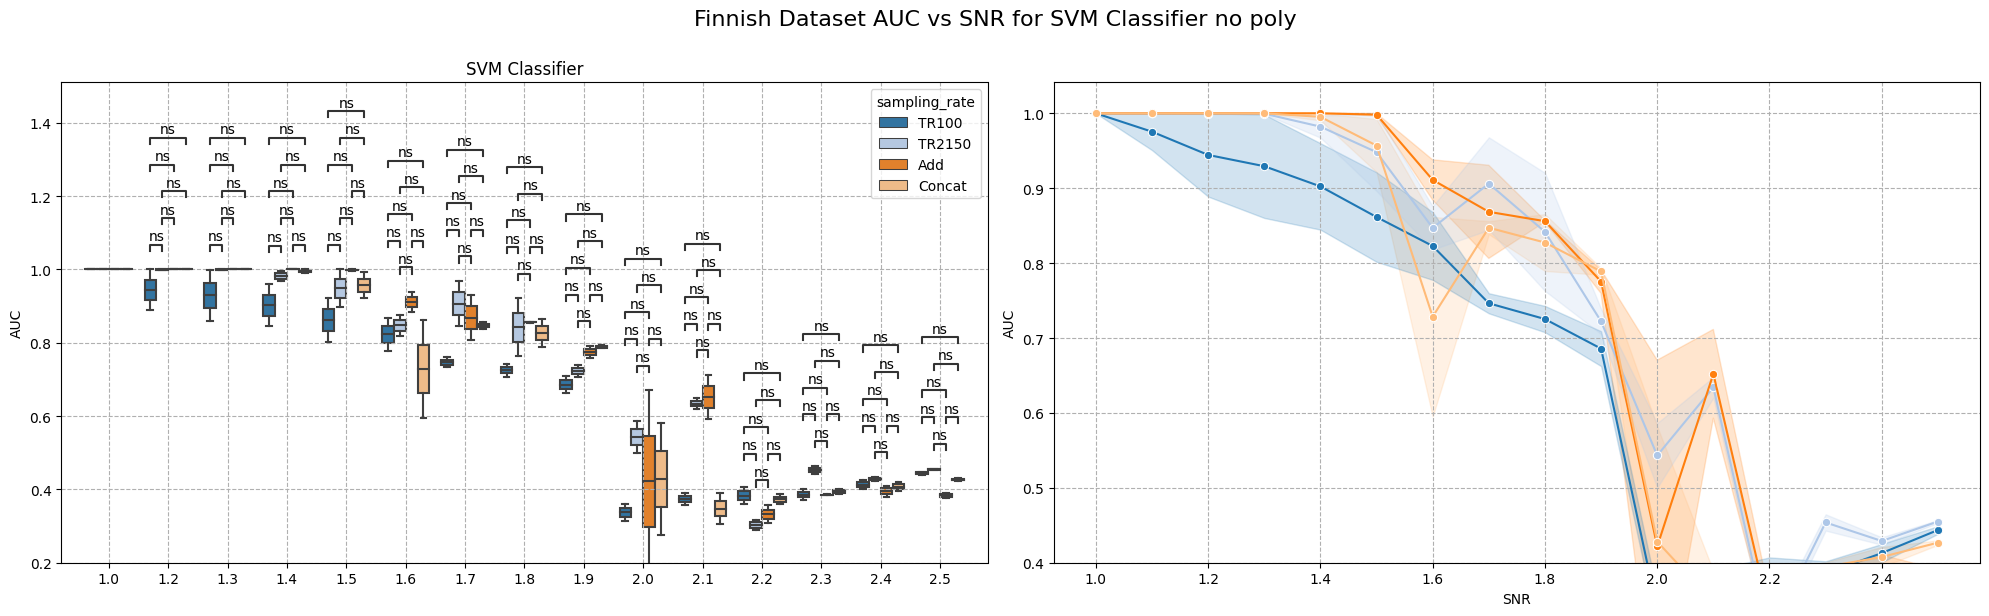

In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from statannotations.Annotator import Annotator
import numpy as np
from scipy.stats import wilcoxon
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

# Define the directory for the current undersampling rate
pkl_dir = f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files'

# Read and concatenate data with 'nopoly' in the filename
joined_files = os.path.join(pkl_dir, '*nopoly*.pkl')
joined_list = glob.glob(joined_files)

svm_df = pd.concat((pd.read_pickle(file) for file in joined_list), ignore_index=True)


sampling_rates = ['TR100', 'TR2150', 'Add', 'Concat']
hue_order = sampling_rates
palette = {item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

snr_levels = [1.0, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
lower_limit = 1.0
svm_df = svm_df[svm_df['snr'] >= lower_limit]

# Define your variables
x = "snr"
y = "roc"
hue = "sampling_rate"
order = snr_levels

# Create the figure and the axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Boxplot
sns.boxplot(
    x=x, y=y, hue=hue, data=svm_df, ax=axes[0], palette=palette,
    order=order, hue_order=hue_order, showfliers=False
)

# Lineplot with error bands
summary_df = svm_df.groupby([x, hue]).agg(
    mean_auc=(y, 'mean'),
    std_auc=(y, 'std'),
    count=(y, 'count')
).reset_index()
summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])

sns.lineplot(
    data=summary_df, x=x, y='mean_auc', hue=hue, hue_order=hue_order,
    palette=palette, marker='o', ax=axes[1], legend=None
)

# Add error bands manually
for key, grp in summary_df.groupby(hue):
    color = palette[key]
    axes[1].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)

axes[0].set_title('SVM Classifier')
axes[0].set_ylim(0.2)
axes[1].set_ylim(0.4)
axes[0].set_xlabel('')
axes[0].set_ylabel('AUC')
axes[1].set_ylabel('AUC')
axes[1].set_xlabel('SNR')

# Generate pairs for comparisons specific to the filtered data
pairs = []
for snr_level in order:
    for pair in combinations(hue_order, 2):
        if pair not in [('sr1', 'sr2'), ('add', 'concat')]:  # Exclude specific pairs
            pairs.append(((snr_level, pair[0]), (snr_level, pair[1])))

# Function to check if Wilcoxon test can be performed
def can_perform_wilcoxon(group1, group2):
    try:
        stat, p = wilcoxon(group1, group2)
        return True
    except ValueError:
        return False

valid_pairs = []
for pair in pairs:
    snr_level = pair[0][0]
    group1 = svm_df[(svm_df[x] == snr_level) & (svm_df[hue] == pair[0][1])][y]
    group2 = svm_df[(svm_df[x] == snr_level) & (svm_df[hue] == pair[1][1])][y]
    if can_perform_wilcoxon(group1, group2):
        valid_pairs.append(pair)

# Annotate the plot
annotator = Annotator(axes[0], valid_pairs, data=svm_df, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
annotator.configure(test='Mann-Whitney', verbose=2)
annotator.apply_and_annotate()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Add a super title
fig.suptitle(f"Finnish Dataset AUC vs SNR for SVM Classifier no poly", fontsize=16, y=1.02)

# Add grid
for ax in axes:
    ax.grid(True, which='both', axis='both', linestyle='--')

# Save the combined plot
plt.savefig('oulu_hue_layout_combined_svm.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


tc_data.shape - (140, 53)
tc_data.shape - (53, 140)
Processed subject 0
tc_data.shape - (140, 53)
tc_data.shape - (53, 140)
Processed subject 1
tc_data.shape - (140, 53)
tc_data.shape - (53, 140)


Processed subject 2
tc_data.shape - (140, 53)
tc_data.shape - (53, 140)
Processed subject 3
tc_data.shape - (140, 53)
tc_data.shape - (53, 140)


ValueError: num must be 1 <= num <= 16, not 17

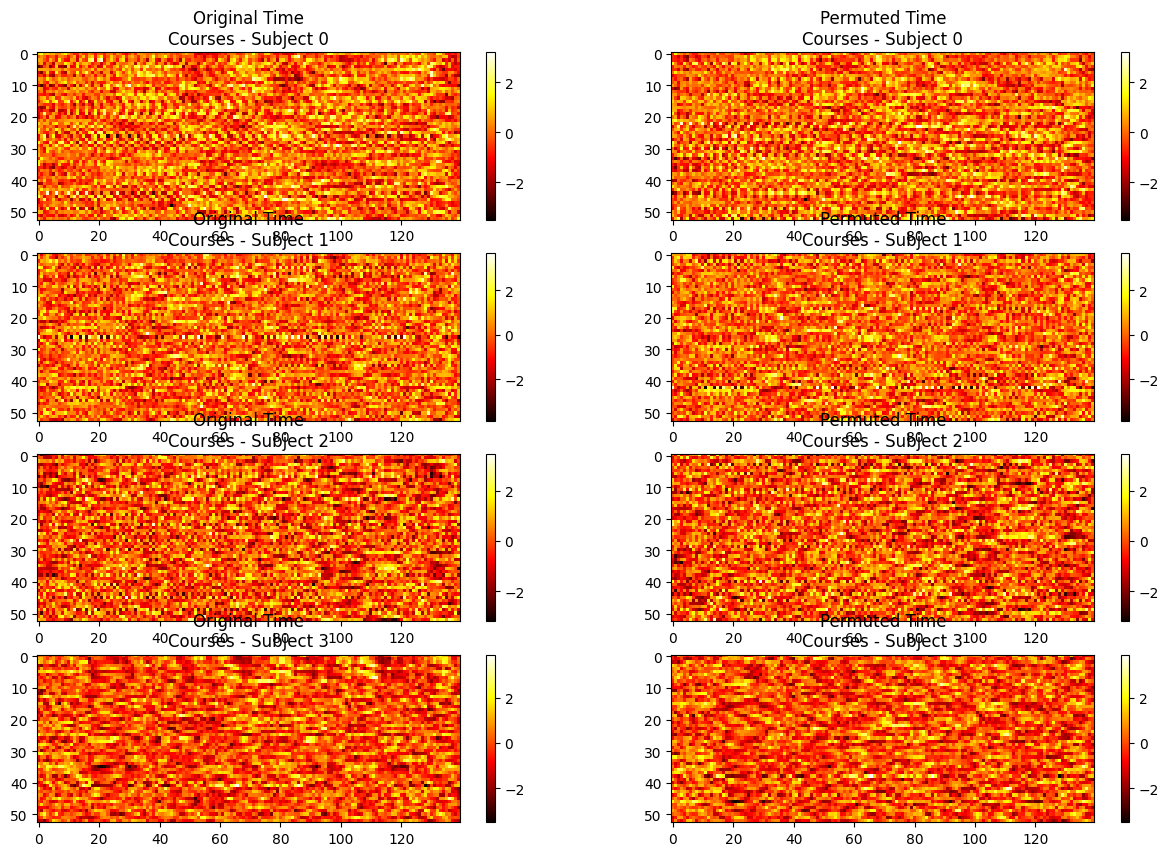

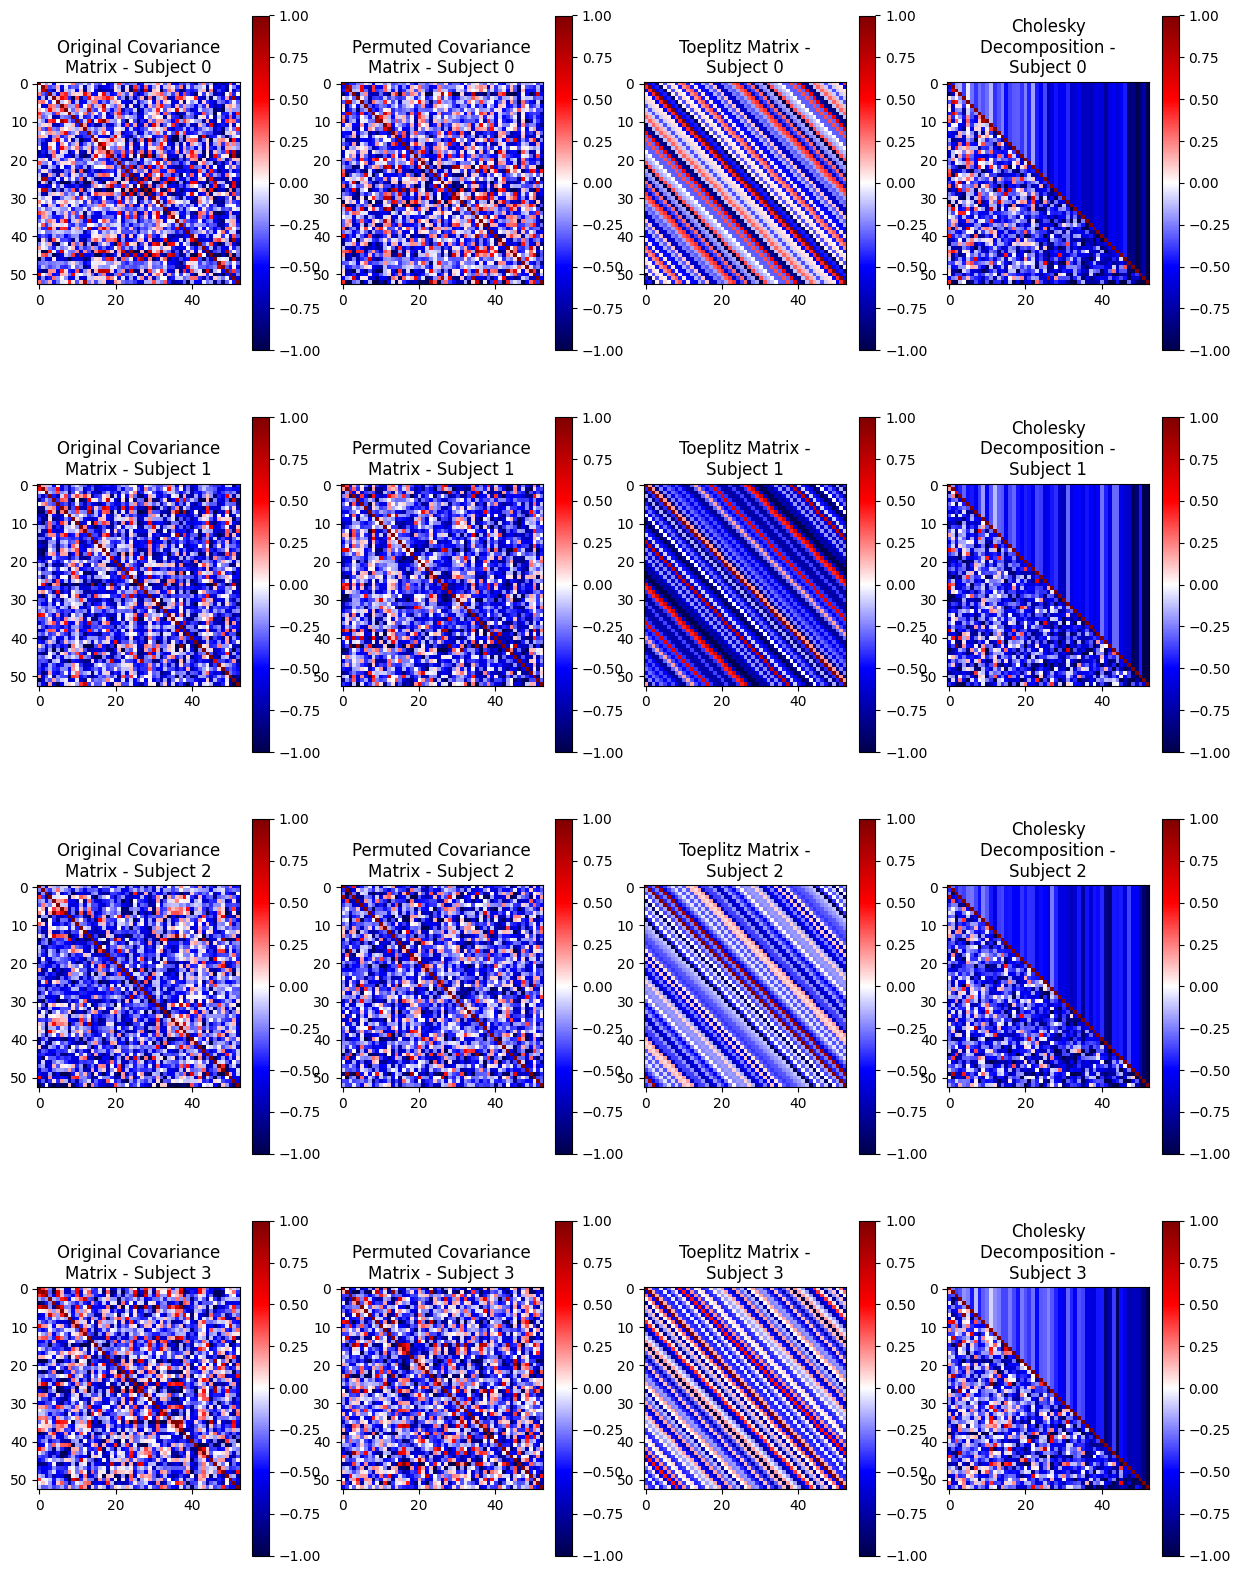

In [11]:
import h5py
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import cholesky, LinAlgError
from textwrap import wrap

# Function to load COBRE data
def load_data(
    dataset_path: str = "/data/users2/ppopov1/datasets/cobre/COBRE_AllData.h5",
    indices_path: str = "/data/users2/ppopov1/datasets/cobre/correct_indices_GSP.csv",
    labels_path: str = "/data/users2/ppopov1/datasets/cobre/labels_COBRE.csv",
):
    """
    Return COBRE data
    """
    # get data
    hf = h5py.File(dataset_path, "r")
    data = hf.get("COBRE_dataset")
    data = np.array(data)
    # reshape data
    num_subjects = data.shape[0]
    num_components = 100
    data = data.reshape(num_subjects, num_components, -1)
    # get correct indices/components
    indices = pd.read_csv(indices_path, header=None)
    idx = indices[0].values - 1
    # filter the data: leave only correct components
    data = data[:, idx, :]
    # get labels
    labels = pd.read_csv(labels_path, header=None)
    labels = labels.values.flatten().astype("int") - 1
    data = np.swapaxes(data, 1, 2)
    # data.shape = [n_samples, time_length, feature_size]
    return data, labels

# Function to create Toeplitz matrix from covariance matrix
def create_toeplitz(permuted_cov_mat):
    n, _ = permuted_cov_mat.shape
    first_col = permuted_cov_mat[0]
    toeplitz_mat = np.zeros((n, n))
    for i in range(n):
        toeplitz_mat[i] = np.roll(first_col, i)
    return toeplitz_mat

# Load COBRE data
cobre_data, labels = load_data()
subject_ids = range(cobre_data.shape[0])

# Path for saving results
cov_path = '/data/users2/jwardell1/nshor_docker/examples/cobre-project/COV'
if not os.path.exists(cov_path):
    os.makedirs(cov_path)

# Initialize subplot index for covariance and Cholesky matrices
idx = 1
plt.figure(1, figsize=(15, 20))

# Initialize subplot index for time courses
tc_idx = 1
plt.figure(2, figsize=(15, 10))

# Process each subject
for subID in subject_ids:
    tc_data = cobre_data[subID]
    print(f'tc_data.shape - {tc_data.shape}')

    if tc_data.shape[0] != 53:
        tc_data = tc_data.T
    
    print(f'tc_data.shape - {tc_data.shape}')

    # Detrend time course data
    tc_data = signal.detrend(tc_data, axis=1)
    
    # Compute original covariance matrix
    cov_mat_original = np.cov(tc_data, rowvar=True)

    # Permute columns randomly
    permuted_indices = np.random.permutation(tc_data.shape[0])
    permuted_tc_data = tc_data[permuted_indices, :]

    # Compute permuted covariance matrix
    cov_mat_permuted = np.cov(permuted_tc_data, rowvar=True)
    
    # Compute Toeplitz matrix from permuted covariance matrix
    toeplitz_mat = create_toeplitz(cov_mat_permuted)
    
    try:
        # Find Cholesky decomposition of permuted covariance matrix
        chol_matrix = cholesky(cov_mat_permuted, lower=True)
    except LinAlgError as e:
        chol_matrix = None
        print(f'Cholesky decomposition failed for Subject {subID} - {e}')
    
    # Save Toeplitz matrix and Cholesky decomposition as .npy
    toeplitz_file = os.path.join(cov_path, f'{subID}_toeplitz.npy')
    np.save(toeplitz_file, toeplitz_mat, allow_pickle=True)
    
    if chol_matrix is not None:
        chol_file = os.path.join(cov_path, f'{subID}_chol.npy')
        np.save(chol_file, chol_matrix, allow_pickle=True)
        cov_file = os.path.join(cov_path, f'{subID}_cov.npy')
        np.save(cov_file, cov_mat_permuted, allow_pickle=True)
    
    # Scale matrices for plotting
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    cov_mat_original_scaled = scaler.fit_transform(cov_mat_original)
    cov_mat_permuted_scaled = scaler.fit_transform(cov_mat_permuted)
    toeplitz_mat_scaled = scaler.fit_transform(toeplitz_mat)
    
    if chol_matrix is not None:
        chol_matrix_scaled = scaler.fit_transform(chol_matrix)
    
    # Plot scaled original and permuted covariance matrices
    plt.figure(1)
    plt.subplot(4, 4, idx)
    plt.imshow(cov_mat_original_scaled, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
    plt.colorbar()
    title = f'Original Covariance Matrix - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    plt.subplot(4, 4, idx + 1)
    plt.imshow(cov_mat_permuted_scaled, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
    plt.colorbar()
    title = f'Permuted Covariance Matrix - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    # Plot scaled Toeplitz matrix and Cholesky decomposition
    plt.subplot(4, 4, idx + 2)
    plt.imshow(toeplitz_mat_scaled, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
    plt.colorbar()
    title = f'Toeplitz Matrix - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    if chol_matrix is not None:
        plt.subplot(4, 4, idx + 3)
        plt.imshow(chol_matrix_scaled, cmap=plt.get_cmap('seismic'), vmin=-1, vmax=1)
        plt.colorbar()
        title = f'Cholesky Decomposition - Subject {subID}'
        plt.title("\n".join(wrap(title, 20)))
    
    # Increment subplot index by 4
    idx += 4

    # Plot original and permuted time course data as heatmap
    plt.figure(2)
    plt.subplot(4, 2, tc_idx)
    plt.imshow(tc_data, aspect='auto', cmap='hot', interpolation='nearest')
    plt.colorbar()
    title = f'Original Time Courses - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    plt.subplot(4, 2, tc_idx + 1)
    plt.imshow(permuted_tc_data, aspect='auto', cmap='hot', interpolation='nearest')
    plt.colorbar()
    title = f'Permuted Time Courses - Subject {subID}'
    plt.title("\n".join(wrap(title, 20)))
    
    # Increment time course subplot index by 2
    tc_idx += 2

    print(f'Processed subject {subID}')

# Adjust layout and show the covariance, Toeplitz, and Cholesky matrices plots
plt.figure(1)
plt.tight_layout()
plt.show()

# Adjust layout and show the time course plots
plt.figure(2)
plt.tight_layout()
plt.show()



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.0_sr2 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.598e-03 U_stat=1.100e+01
1.9_sr2 vs. 1.9_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.827e-04 U_stat=0.000e+00
1.5_sr2 vs. 1.5_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.498e-02 U_stat=3.000e+01
1.6_sr2 vs. 1.6_add: Mann-Whitney-Wilcoxon test two-sided, P_val:6.328e-03 U_stat=1.750e+01
1.7_sr2 vs. 1.7_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.245e-02 U_stat=1.750e+01
1.8_sr2 vs. 1.8_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.547e-02 U_stat=2.450e+01
1.9_sr1 vs. 1.9_add: Mann-Whitney-Wilcoxon test two-sided, P_val:4.480e-01 U_stat=3.950e+01
2.0_sr1 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:6.302e-02 U_stat=2.500e+01
2.0_sr2 vs. 2.0_concat: Mann-Whitney-Wilcoxon test two-sided, P_val:5.70

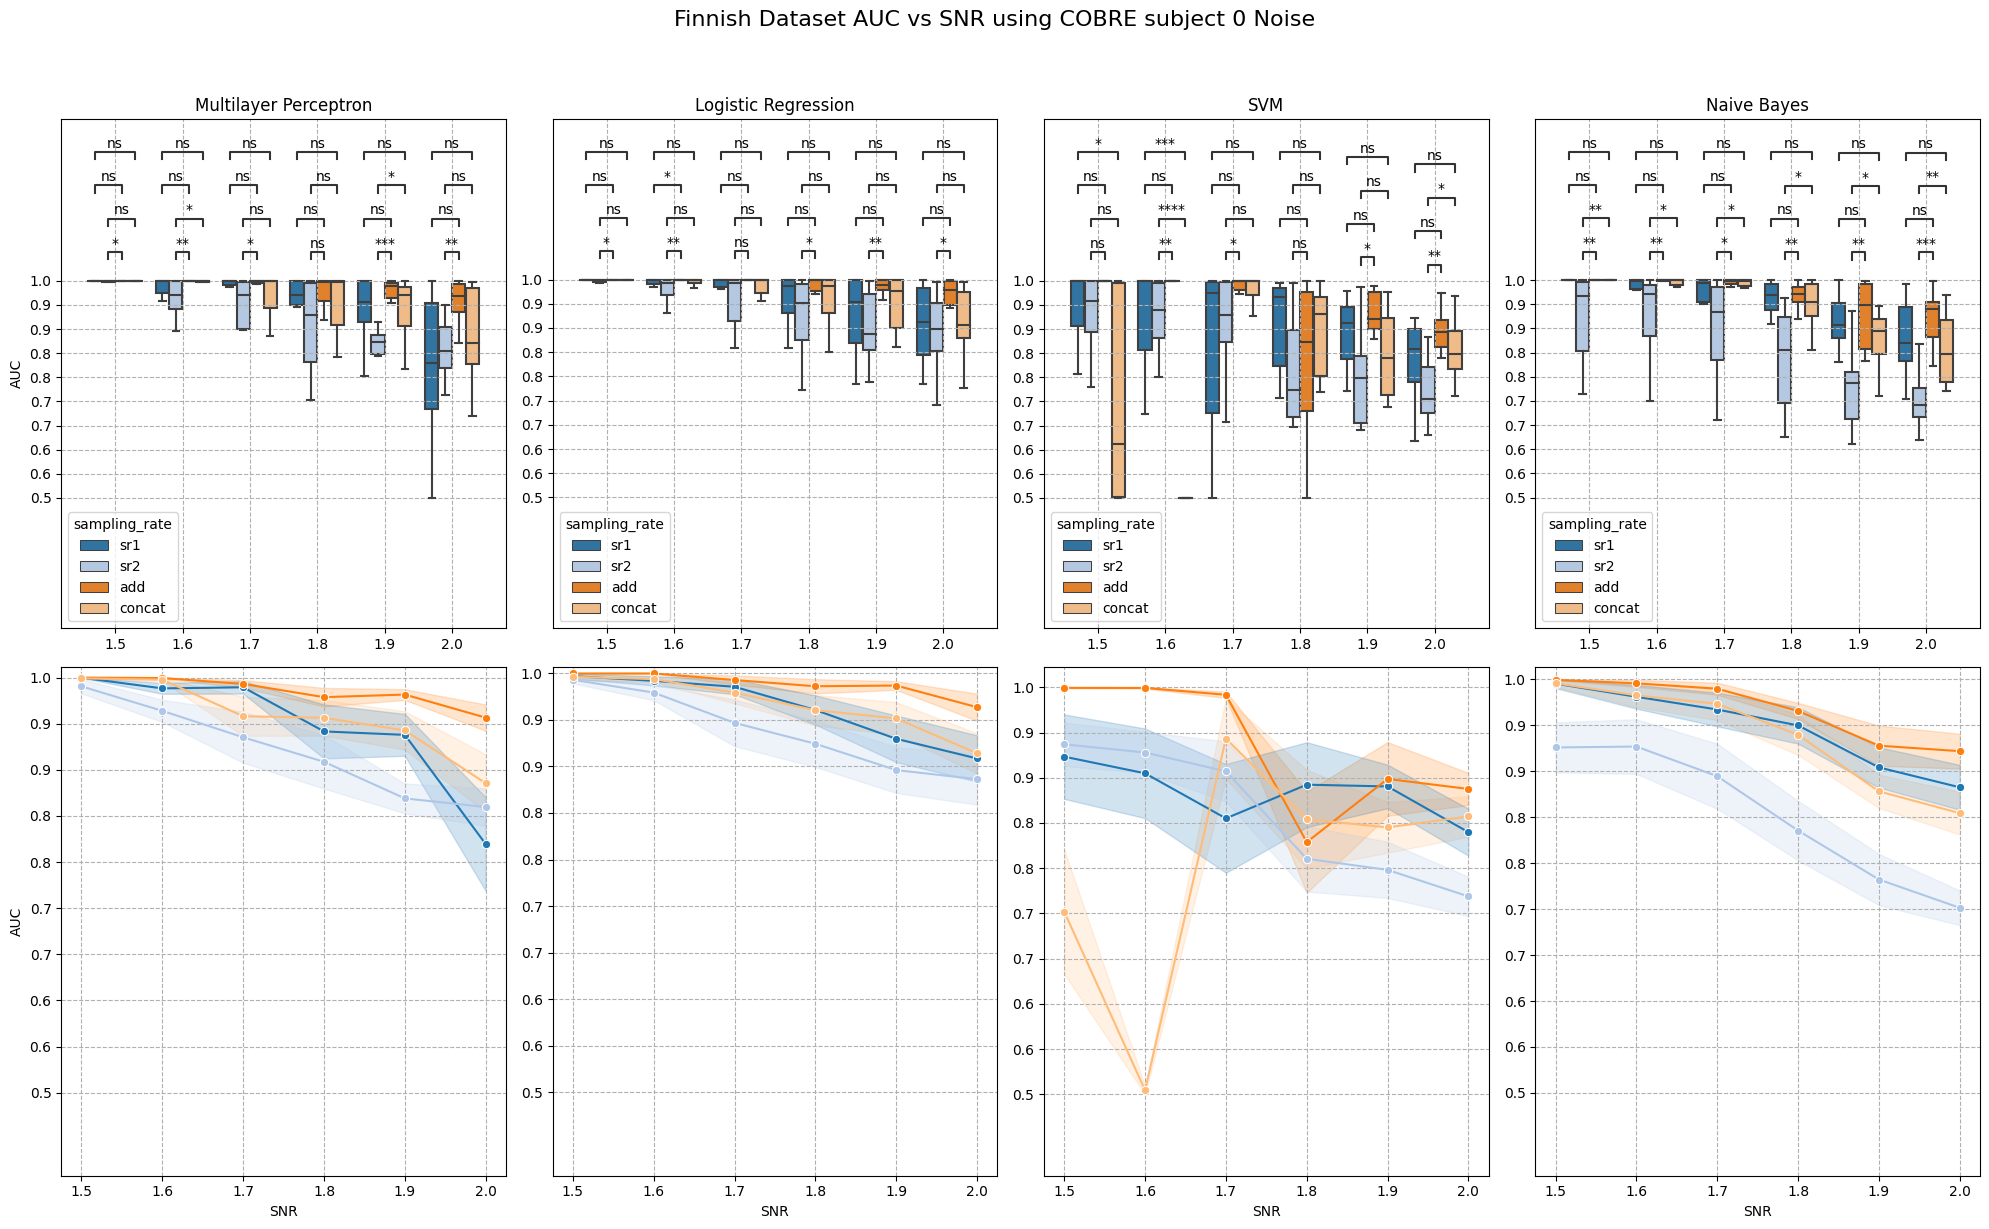

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.0_sr2 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.388e-02 U_stat=1.700e+01
1.9_sr2 vs. 1.9_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.309e-03 U_stat=7.000e+00
1.5_sr2 vs. 1.5_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.487e-02 U_stat=2.500e+01
1.6_sr2 vs. 1.6_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.245e-02 U_stat=1.750e+01
1.7_sr2 vs. 1.7_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.819e-03 U_stat=1.300e+01
1.8_sr2 vs. 1.8_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.786e-03 U_stat=1.000e+01
1.9_sr1 vs. 1.9_add: Mann-Whitney-Wilcoxon test two-sided, P_val:7.456e-02 U_stat=2.600e+01
2.0_sr1 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.036e-01 U_stat=3.600e+01
2.0_sr2 vs. 2.0_concat: Mann-Whitney-Wilcoxon test two-sided, P_val:6.40

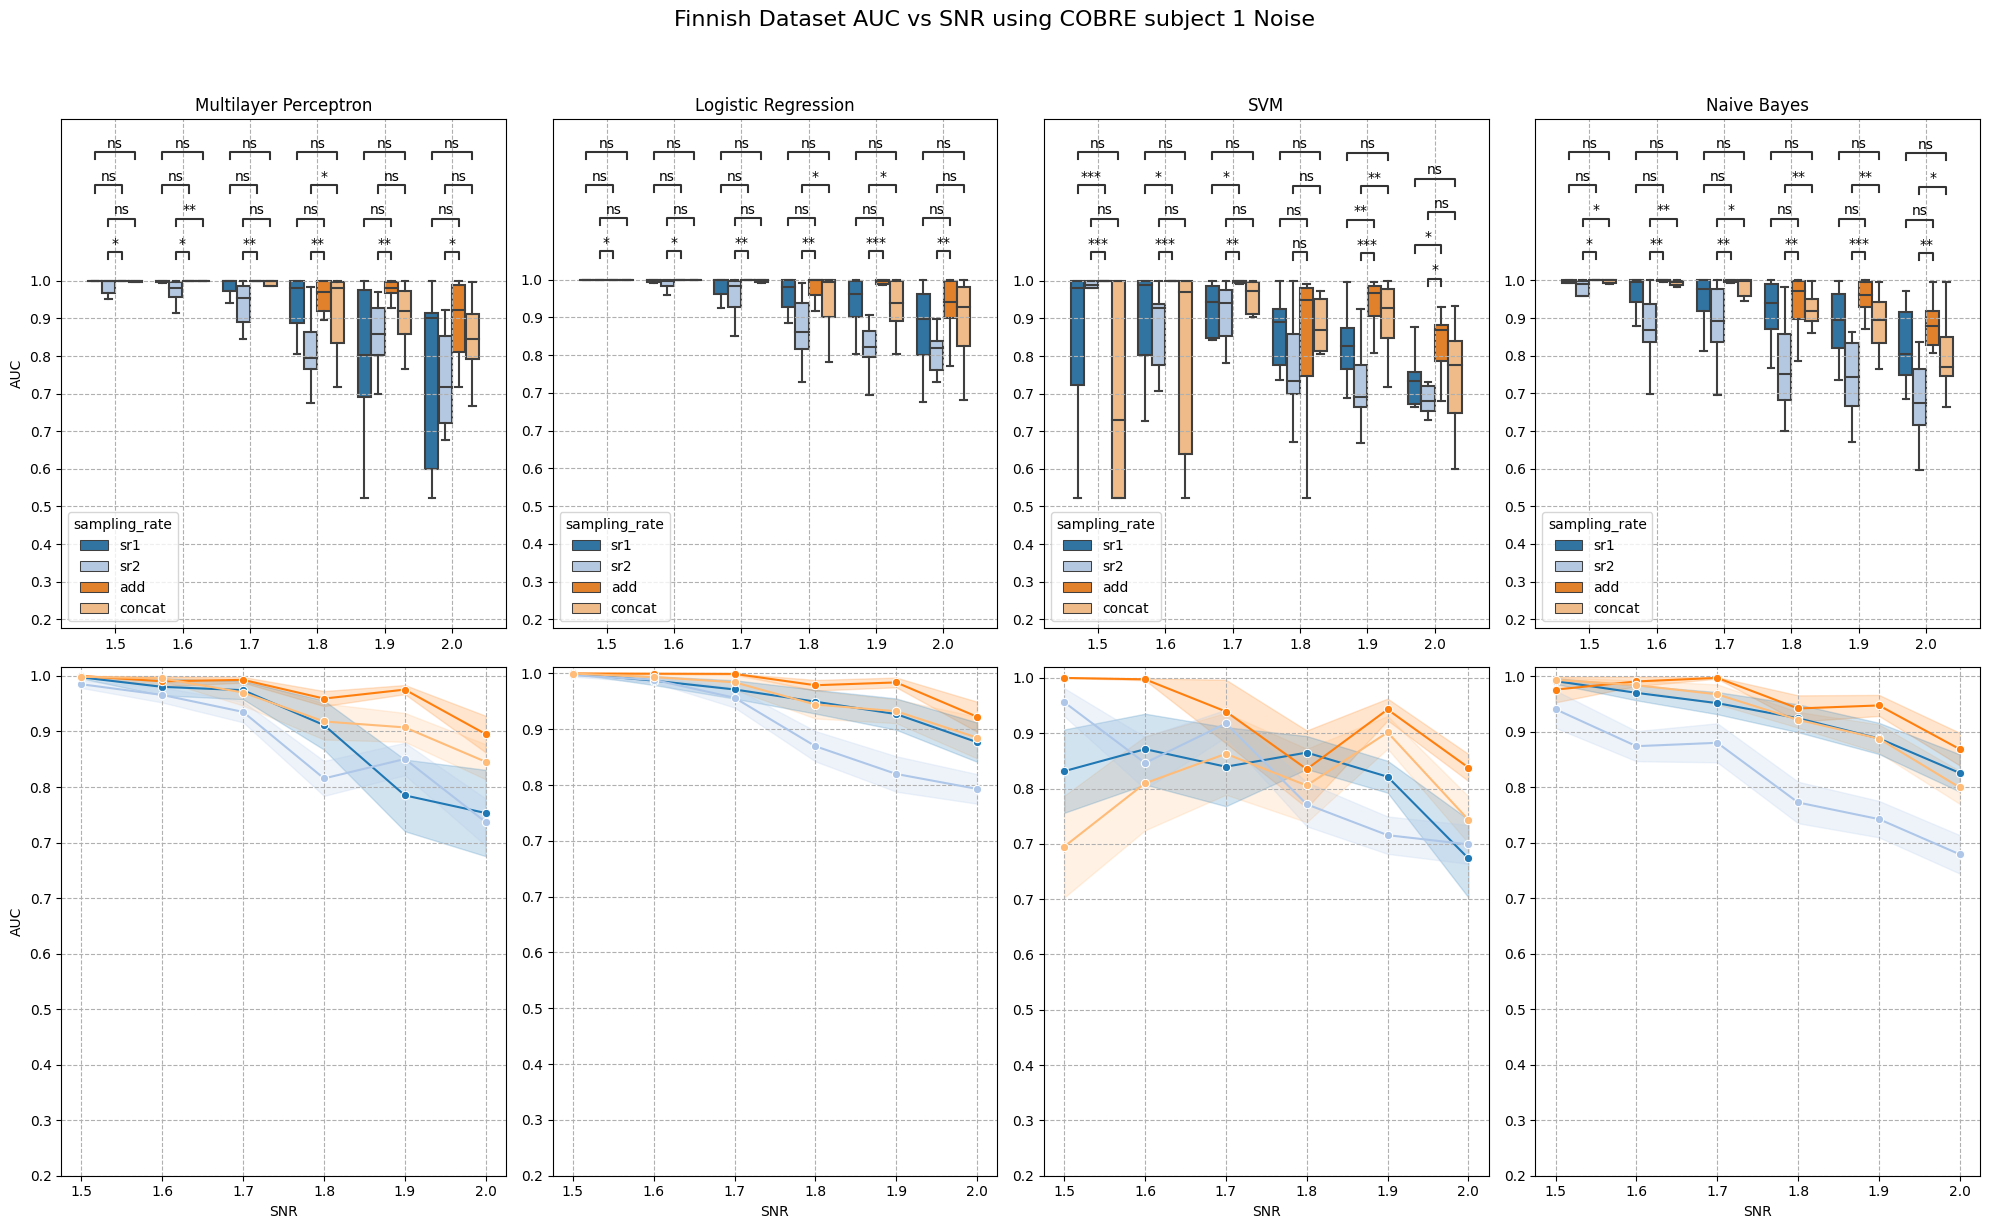

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.0_sr2 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.560e-03 U_stat=1.100e+01
1.9_sr2 vs. 1.9_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.560e-03 U_stat=1.100e+01
1.5_sr2 vs. 1.5_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.972e-03 U_stat=2.000e+01
1.6_sr2 vs. 1.6_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.100e-04 U_stat=5.000e+00
1.7_sr2 vs. 1.7_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.724e-04 U_stat=2.000e+00
1.8_sr2 vs. 1.8_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.602e-03 U_stat=1.150e+01
1.9_sr1 vs. 1.9_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.624e-01 U_stat=4.200e+01
2.0_sr1 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.811e-01 U_stat=3.800e+01
2.0_sr2 vs. 2.0_concat: Mann-Whitney-Wilcoxon test two-sided, P_val:1.72

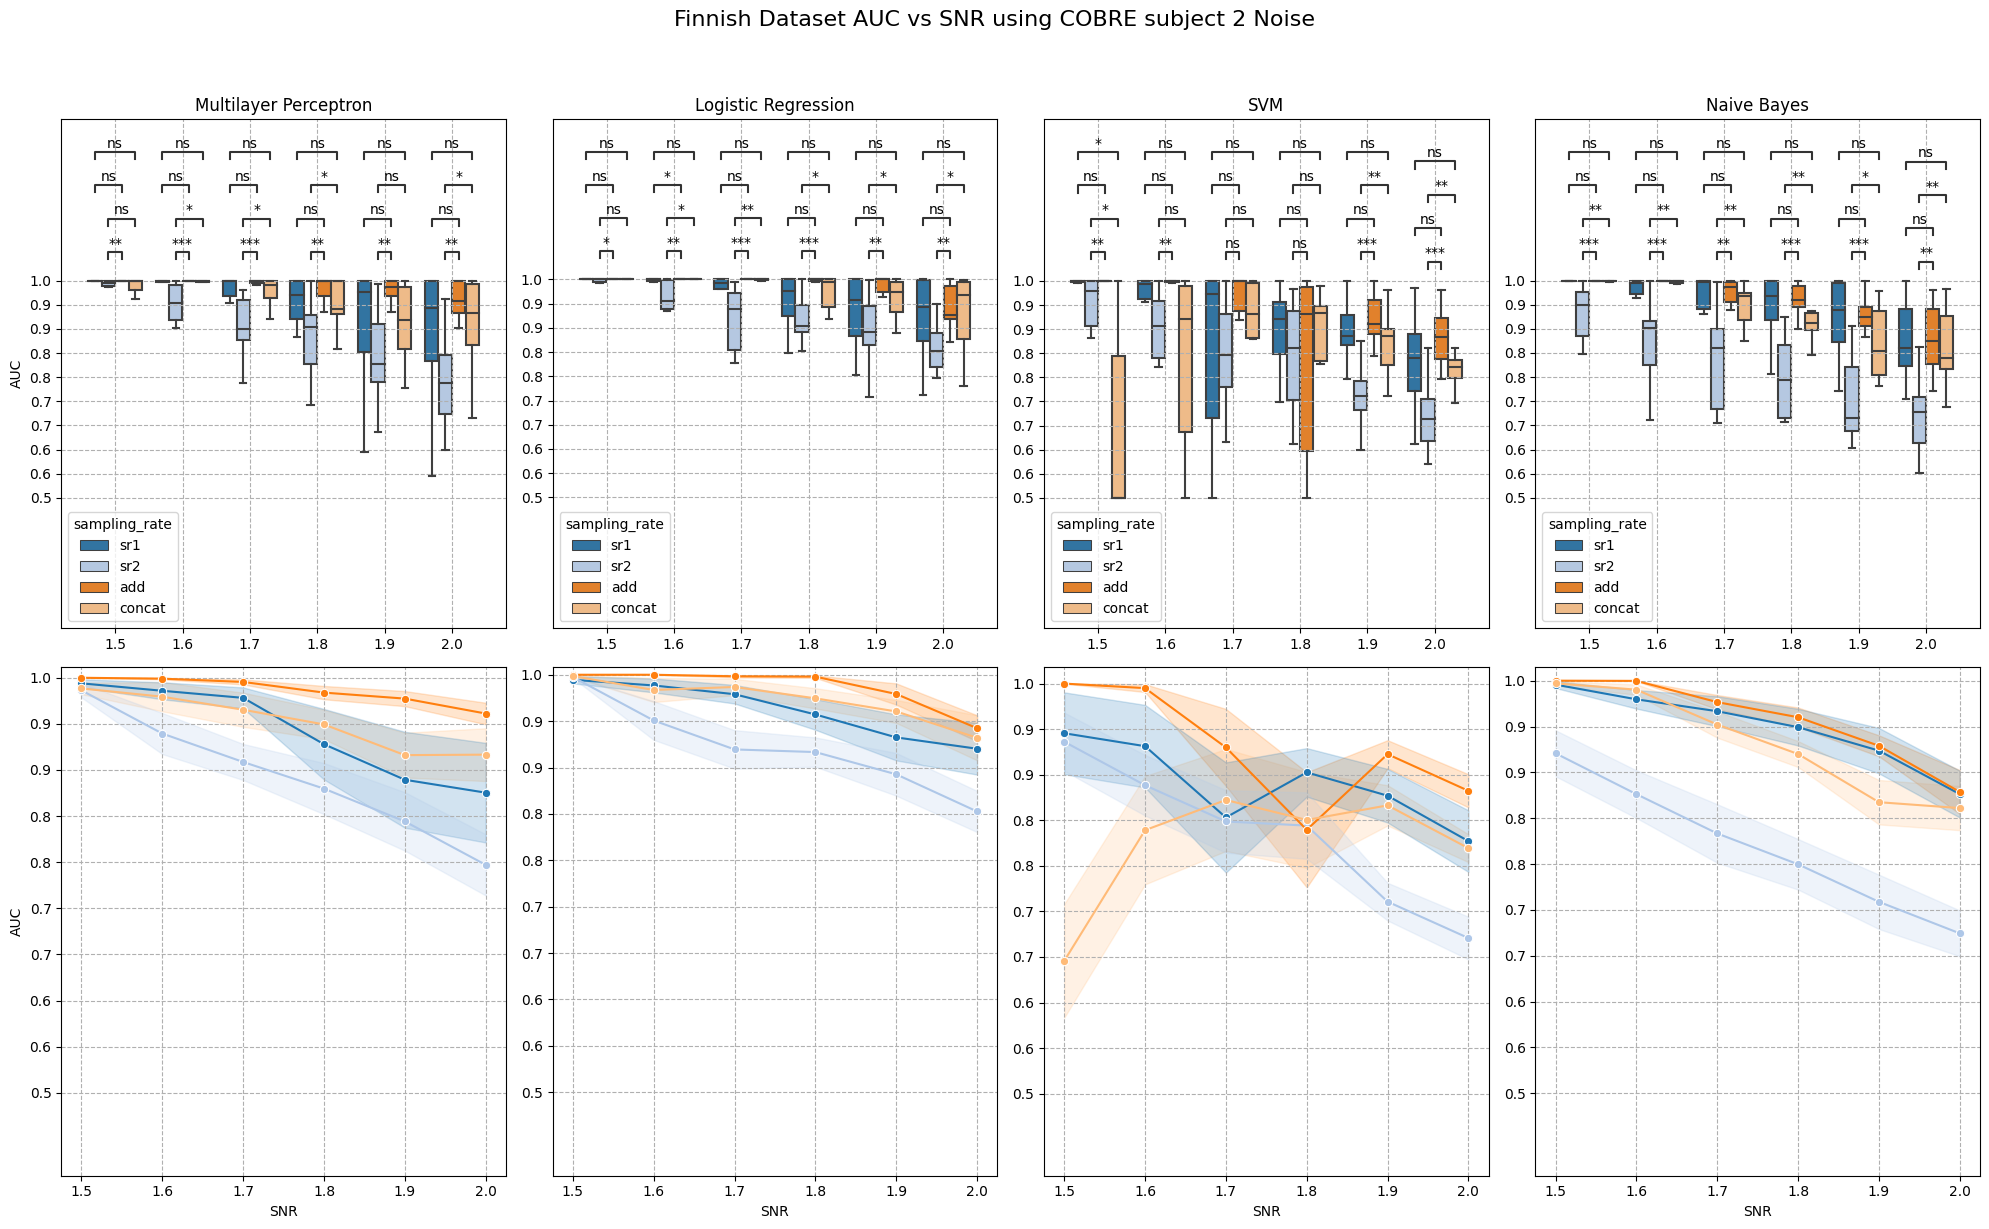

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.0_sr2 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:2.448e-04 U_stat=1.000e+00
1.9_sr2 vs. 1.9_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.210e-02 U_stat=2.400e+01
1.5_sr2 vs. 1.5_add: Mann-Whitney-Wilcoxon test two-sided, P_val:5.842e-01 U_stat=4.500e+01
1.6_sr2 vs. 1.6_add: Mann-Whitney-Wilcoxon test two-sided, P_val:3.760e-01 U_stat=4.000e+01
1.7_sr2 vs. 1.7_add: Mann-Whitney-Wilcoxon test two-sided, P_val:4.509e-01 U_stat=4.100e+01
1.8_sr2 vs. 1.8_add: Mann-Whitney-Wilcoxon test two-sided, P_val:4.068e-02 U_stat=2.300e+01
1.9_sr1 vs. 1.9_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.375e-01 U_stat=3.000e+01
2.0_sr1 vs. 2.0_add: Mann-Whitney-Wilcoxon test two-sided, P_val:1.390e-01 U_stat=3.000e+01
2.0_sr2 vs. 2.0_concat: Mann-Whitney-Wilcoxon test two-sided, P_val:5.82

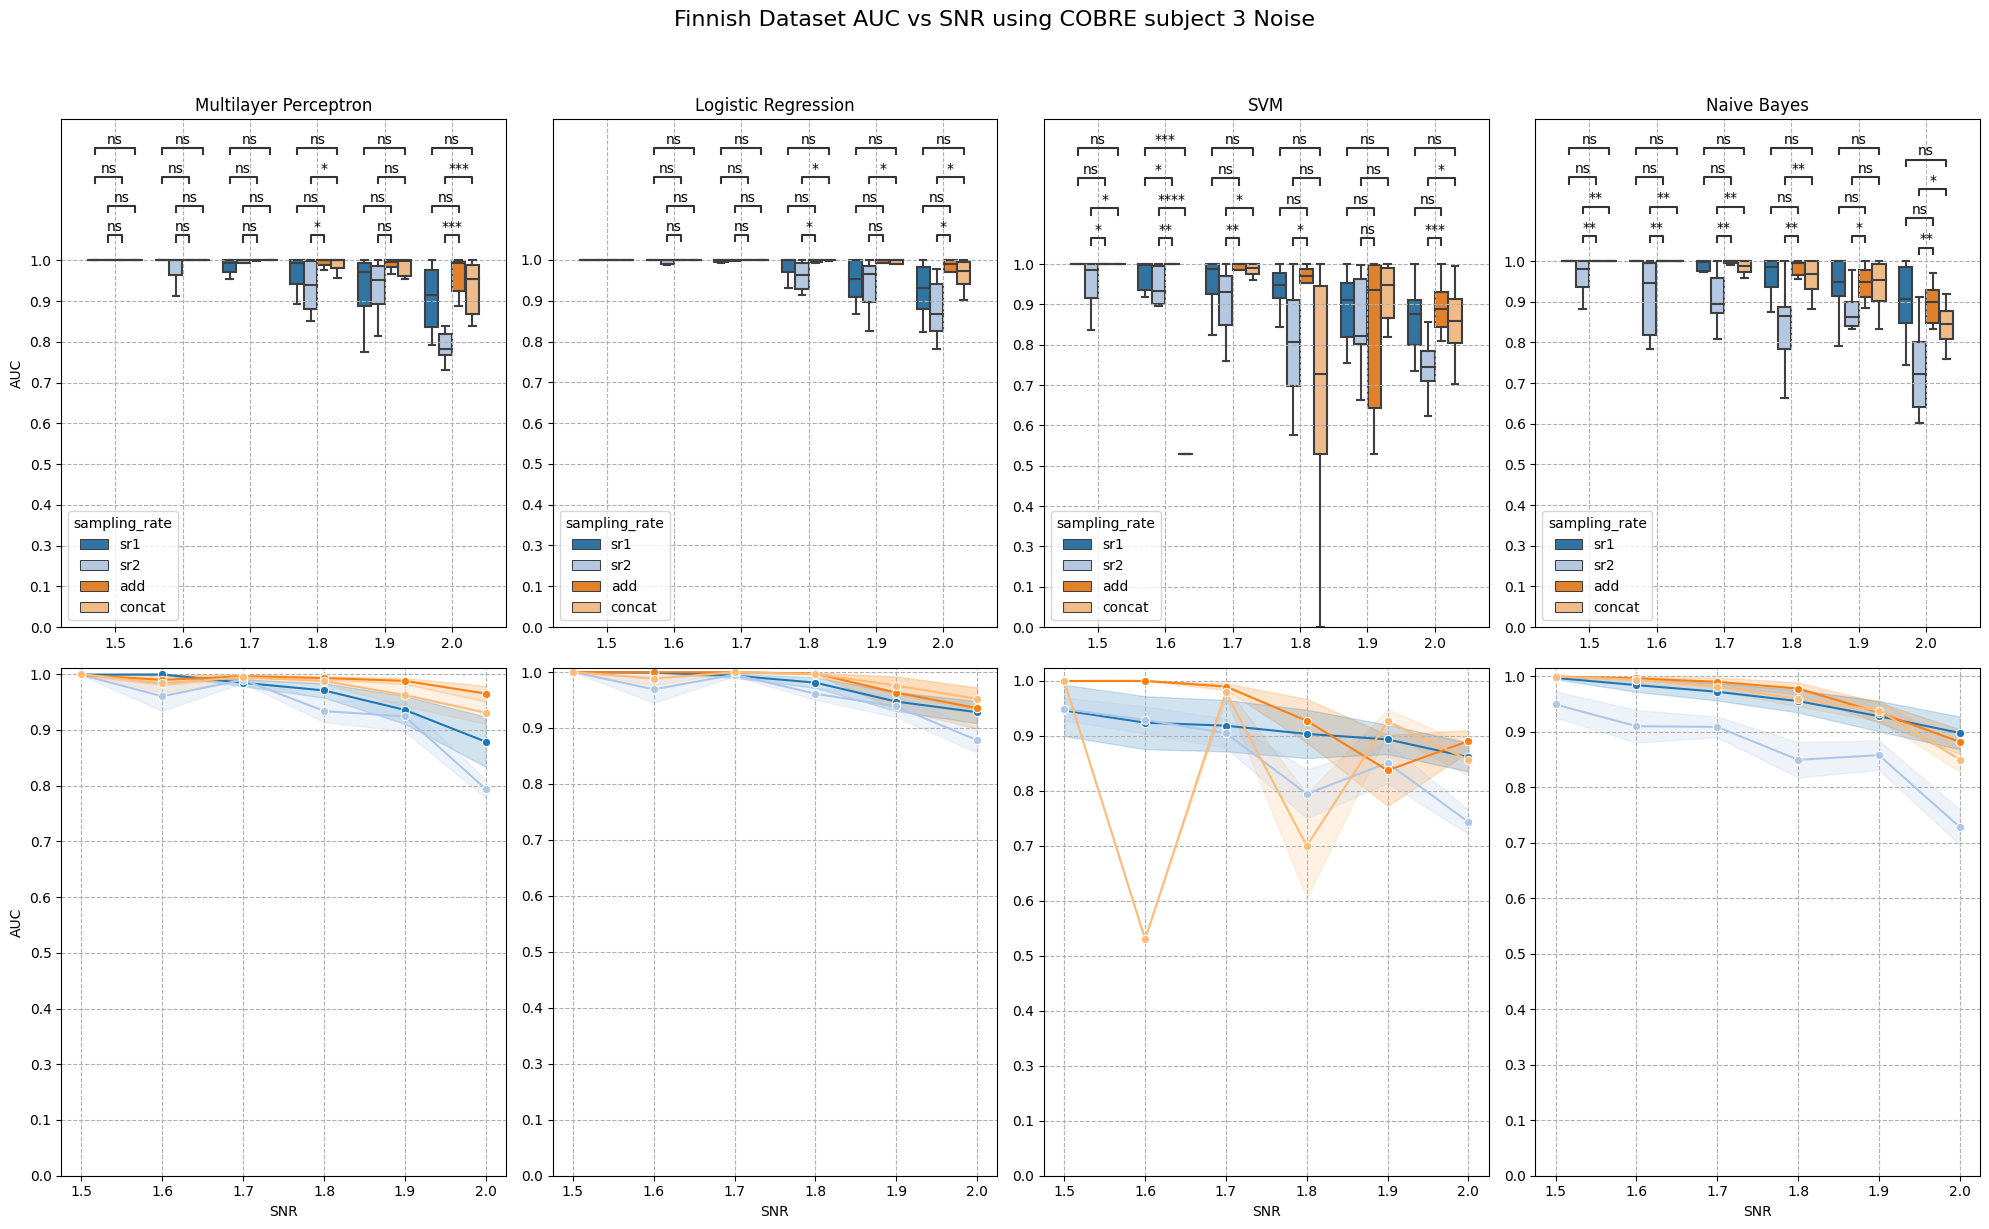

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from statannotations.Annotator import Annotator
import numpy as np
from scipy.stats import wilcoxon

# List of subject IDs
subject_ids = [
    0,
    1,
    2,
    3
]

for subID in subject_ids:
    # Define the directory for the current undersampling rate
    pkl_dir = f'/data/users2/jwardell1/undersampling-project/OULU/pkl-files/{subID}'

    # Read and concatenate sr1 data
    joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
    joined_list = glob.glob(joined_files)
    sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

    # Read and concatenate sr2 data
    joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
    joined_list = glob.glob(joined_files)
    sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

    # Read and concatenate concat data
    joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
    joined_list = glob.glob(joined_files)
    concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

    # Read and concatenate add data
    joined_files = os.path.join(pkl_dir, 'add_*.pkl')
    joined_list = glob.glob(joined_files)
    add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)

    # Concatenate all dataframes
    all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)

    # Function to split each row into multiple rows based on cross-validation index
    def split_row(row):
        new_rows = []
        for cv_ix, auc in enumerate(row['test_scores']):
            new_row = row.copy()
            new_row['auc'] = auc
            new_row['cv_ix'] = cv_ix
            new_rows.append(new_row)
        return pd.DataFrame(new_rows)

    # Apply the split_row function to each row of the dataframe and concatenate the results
    result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)

    # Drop the original 'test_scores' column as it's no longer needed
    result_df.drop('test_scores', axis=1, inplace=True)

    grouped_classifiers = result_df.groupby('classifier')

    classifier_dfs = {}
    for classifier, group_df in grouped_classifiers:
        classifier_dfs[classifier] = group_df.copy()

    mlp_df = classifier_dfs['Multilayer Perceptron']
    lr_df = classifier_dfs['Logistic Regression']
    svm_df = classifier_dfs['SVM']
    nb_df = classifier_dfs['Naive Bayes']

    dfs = [mlp_df, lr_df, svm_df, nb_df]
    #dfs = [lr_df, svm_df, nb_df]
    classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
    #classifiers = ['Logistic Regression', 'SVM', 'Naive Bayes']
    sampling_rates = ['sr1', 'sr2', 'add', 'concat']
    hue_order = sampling_rates
    palette = {item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

    # Combine all dataframes into one dataframe for plotting
    combined_df = pd.concat(dfs)
    snr_levels = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    #snr_levels = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

    lower_limit = 1.5
    combined_df = combined_df[combined_df['snr'] >= lower_limit]

    # Define your variables
    x = "snr"
    y = "auc"
    hue = "sampling_rate"
    order = snr_levels

    # Create the figure and the axes
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), gridspec_kw={'height_ratios': [1, 1]})

    # Collect y-limits for determining the common range
    all_y_vals = []

    for i, classifier in enumerate(classifiers):
        # Filter the data for the current classifier
        data_filtered = combined_df[combined_df['classifier'] == classifier]
        
        # Boxplot
        sns.boxplot(
            x=x, y=y, hue=hue, data=data_filtered, ax=axes[0, i], palette=palette,
            order=order, hue_order=hue_order, showfliers=False
        )

        # Lineplot with error bands
        summary_df = data_filtered.groupby([x, hue]).agg(
            mean_auc=(y, 'mean'),
            std_auc=(y, 'std'),
            count=(y, 'count')
        ).reset_index()
        summary_df['se_auc'] = summary_df['std_auc'] / np.sqrt(summary_df['count'])
        
        sns.lineplot(
            data=summary_df, x=x, y='mean_auc', hue=hue, hue_order=hue_order,
            palette=palette, marker='o', ax=axes[1, i], legend=None
        )
        
        # Add error bands manually
        for key, grp in summary_df.groupby(hue):
            color = palette[key]
            axes[1, i].fill_between(grp[x], grp['mean_auc'] - grp['se_auc'], grp['mean_auc'] + grp['se_auc'], color=color, alpha=0.2)
        
        # Collect y-values
        all_y_vals.extend(data_filtered[y].values)
        
        axes[0, i].set_title(f'{classifier}')
        axes[0, i].set_ylim(0.2)
        axes[1, i].set_ylim(0.4)
        axes[0, i].set_xlabel('')
        if i == 0:
            axes[0, i].set_ylabel('AUC')
            axes[1, i].set_ylabel('AUC')
        else:
            axes[0, i].set_ylabel('')
            axes[1, i].set_ylabel('')
        
        axes[1, i].set_xlabel('SNR')
        
        # Generate pairs for comparisons specific to the filtered data
        pairs = []
        for snr_level in order:
            for pair in combinations(hue_order, 2):
                if pair not in [('sr1', 'sr2'), ('add', 'concat')]:  # Exclude specific pairs
                    pairs.append(((snr_level, pair[0]), (snr_level, pair[1])))

        # Function to check if Wilcoxon test can be performed
        def can_perform_wilcoxon(group1, group2):
            try:
                stat, p = wilcoxon(group1, group2)
                return True
            except ValueError:
                return False

        valid_pairs = []
        for pair in pairs:
            snr_level = pair[0][0]
            group1 = data_filtered[(data_filtered[x] == snr_level) & (data_filtered[hue] == pair[0][1])][y]
            group2 = data_filtered[(data_filtered[x] == snr_level) & (data_filtered[hue] == pair[1][1])][y]
            if can_perform_wilcoxon(group1, group2):
                valid_pairs.append(pair)

        # Annotate the plot
        annotator = Annotator(axes[0, i], valid_pairs, data=data_filtered, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
        annotator.configure(test='Mann-Whitney', verbose=2)
        annotator.apply_and_annotate()

    # Determine common y-tick range
    min_y = np.min(all_y_vals)
    max_y = np.max(all_y_vals)
    common_ticks = np.linspace(min_y, max_y, num=10)

    # Set common y-ticks and format them for all subplots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_yticks(common_ticks)
            ax.set_yticklabels([f'{tick:.1f}' for tick in common_ticks])

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Add a super title
    fig.suptitle(f"Finnish Dataset AUC vs SNR using COBRE subject {subID} Noise", fontsize=16, y=1.02)

    # Add grid
    for ax_row in axes:
        for ax in ax_row:
            ax.grid(True, which='both', axis='both', linestyle='--')

    # Save the combined plot
    plt.savefig(f'oulu_hue_layout_combined_{subID}.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

